In [1]:
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(10)
tf.keras.backend.set_floatx('float32')

# import xarray as xr
import tensorflow.keras.backend as K
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras import Model

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.optimize import minimize

In [2]:
# z500_raw = xr.load_dataset('/lcrc/project/AIEADA-2/POD_CNN_Comparisons/Cubed_Sphere/Data/tutorial_geopotential_500.nc')
# z500_numpy = np.asarray(z500_raw['z'])[:,0][:,:90]
# # z500_numpy = np.rollaxis(z500_numpy, 1,3)

# np.save('/lcrc/project/AIEADA-2/POD_CNN_Comparisons/Cubed_Sphere/Data/z500_numpy.npy',z500_numpy)

In [3]:
z500_numpy = np.load('/lcrc/project/AIEADA-2/POD_CNN_Comparisons/Cubed_Sphere/Data/z500_numpy.npy')

In [4]:
num_snapshots = z500_numpy.shape[0]
train_snapshots = int(0.75*num_snapshots)
# z500_train = np.expand_dims(z500_numpy[:train_snapshots],axis=-1)
# z500_test = np.expand_dims(z500_numpy[train_snapshots:],axis=-1)
z500_train = z500_numpy[:train_snapshots]
z500_test = z500_numpy[train_snapshots:]

scaler = MinMaxScaler()
data_shape = z500_train.shape
z500_train = scaler.fit_transform(z500_train.reshape(data_shape[0],-1)).reshape(data_shape)

data_shape = z500_test.shape
z500_test = scaler.transform(z500_test.reshape(data_shape[0],-1)).reshape(data_shape)

In [5]:
z500_train.shape

(87660, 90, 180)

In [6]:
class PeriodicPadding2D(ZeroPadding2D):
    """Periodic-padding layer for 2D input (e.g. image).

    This layer can add periodic rows and columns at the top, bottom, left and right side of an image tensor.

    Adapted from keras.layers.ZeroPadding2D by @jweyn

    # Arguments
        padding: int, or tuple of 2 ints, or tuple of 2 tuples of 2 ints.
            - If int: the same symmetric padding
                is applied to height and width.
            - If tuple of 2 ints:
                interpreted as two different
                symmetric padding values for height and width:
                `(symmetric_height_pad, symmetric_width_pad)`.
            - If tuple of 2 tuples of 2 ints:
                interpreted as
                `((top_pad, bottom_pad), (left_pad, right_pad))`
        data_format: A string,
            one of `"channels_last"` or `"channels_first"`.
            The ordering of the dimensions in the inputs.
            `"channels_last"` corresponds to inputs with shape
            `(batch, height, width, channels)` while `"channels_first"`
            corresponds to inputs with shape
            `(batch, channels, height, width)`.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".

    # Input shape
        4D tensor with shape:
        - If `data_format` is `"channels_last"`:
            `(batch, rows, cols, channels)`
        - If `data_format` is `"channels_first"`:
            `(batch, channels, rows, cols)`

    # Output shape
        4D tensor with shape:
        - If `data_format` is `"channels_last"`:
            `(batch, padded_rows, padded_cols, channels)`
        - If `data_format` is `"channels_first"`:
            `(batch, channels, padded_rows, padded_cols)`
    """

    def __init__(self,
                 padding=(1, 1),
                 data_format=None,
                 **kwargs):
        super(PeriodicPadding2D, self).__init__(padding=padding,
                                                data_format=data_format,
                                                **kwargs)

    def call(self, inputs):
        if K.backend() == 'plaidml.keras.backend':
            shape = inputs.shape.dims
        else:
            shape = inputs.shape
        if self.data_format == 'channels_first':
            top_slice = slice(shape[2] - self.padding[0][0], shape[2])
            bottom_slice = slice(0, self.padding[0][1])
            left_slice = slice(shape[3] - self.padding[1][0], shape[3])
            right_slice = slice(0, self.padding[1][1])
            # Pad the horizontal
            outputs = K.concatenate([inputs[:, :, :, left_slice], inputs, inputs[:, :, :, right_slice]], axis=3)
            # Pad the vertical
            outputs = K.concatenate([outputs[:, :, top_slice], outputs, outputs[:, :, bottom_slice]], axis=2)
        else:
            top_slice = slice(shape[1] - self.padding[0][0], shape[1])
            bottom_slice = slice(0, self.padding[0][1])
            left_slice = slice(shape[2] - self.padding[1][0], shape[2])
            right_slice = slice(0, self.padding[1][1])
            # Pad the horizontal
            outputs = K.concatenate([inputs[:, :, left_slice], inputs, inputs[:, :, right_slice]], axis=2)
            # Pad the vertical
            outputs = K.concatenate([outputs[:, top_slice], outputs, outputs[:, bottom_slice]], axis=1)
        return outputs

In [7]:
class resnet_block(tf.keras.layers.Layer):
    def __init__(self, input_dim_, output_dim_, **kwargs):
        self.input_dim_ = input_dim_
        self.output_dim_ = output_dim_
        super().__init__(**kwargs)
              
        self.make_layers()
        
    def make_layers(self):
        self.main_layer = tf.keras.layers.Conv2D(self.output_dim_[-1],
                     kernel_size=(3,3),
                     activation='swish',
                     kernel_initializer='glorot_normal',bias_initializer='glorot_normal',
                     data_format='channels_last',
                     padding='valid', input_shape=(self.input_dim_[1],self.input_dim_[2],self.input_dim_[3]))
        
        self.skip_layer = tf.keras.layers.Conv2D(self.output_dim_[-1],
                     kernel_size=(1,1),
                     activation='swish',
                     kernel_initializer='glorot_normal',bias_initializer='glorot_normal',
                     data_format='channels_last',
                     padding='valid', input_shape=(self.input_dim_[1],self.input_dim_[2],self.input_dim_[3]))
        
        self.padding_layer = PeriodicPadding2D(data_format='channels_last')
        

    def __call__(self, inputs):
        main_branch = self.main_layer(inputs)
        main_branch = self.padding_layer(main_branch)
        
        skip_branch = self.skip_layer(inputs)
        
        out = tf.keras.layers.add([main_branch, skip_branch])
        return out

In [8]:
class cnn_esm(Model):
    def __init__(self, train_data, input_horizon, output_horizon):
        super(cnn_esm, self).__init__()
        
        self.input_horizon = input_horizon
        self.output_horizon = output_horizon
        
        self.make_data(train_data)
        self.data_shape = train_data.shape
        
        self.make_architecture()
        
    def make_data(self,train_data):
        end_time = self.input_horizon + self.output_horizon
        
        input_data = []
        output_data= []
        for i in range(train_data.shape[0]-end_time):
            temp_inputs = train_data[i:i+self.input_horizon]
            temp_inputs = np.rollaxis(temp_inputs,0,3)
                       
            temp_outputs = train_data[i+self.input_horizon:i+end_time]
            temp_outputs = np.rollaxis(temp_outputs,0,3)
            
            input_data.append(temp_inputs)
            output_data.append(temp_outputs)
            
        self.input_data = np.asarray(input_data)
        self.output_data = np.asarray(output_data)
        
        self.num_snapshots = self.input_data.shape[0]
        self.num_train = int(0.8*self.num_snapshots)
        self.num_valid = self.num_snapshots - self.num_train
        
        self.input_data_train = self.input_data[:self.num_train]
        self.input_data_valid = self.input_data[self.num_train:self.num_train+self.num_valid]
        
        self.output_data_train = self.output_data[:self.num_train]
        self.output_data_valid = self.output_data[self.num_train:self.num_train+self.num_valid]
        
        
    def make_data_test(self,test_data):
        end_time = self.input_horizon + self.output_horizon
        
        input_data = []
        output_data= []
        for i in range(test_data.shape[0]-end_time):
            temp_inputs = test_data[i:i+self.input_horizon]
            temp_inputs = np.rollaxis(temp_inputs,0,3)
                       
            temp_outputs = test_data[i+self.input_horizon:i+end_time]
            temp_outputs = np.rollaxis(temp_outputs,0,3)
            
            input_data.append(temp_inputs)
            output_data.append(temp_outputs)
            
        self.input_data_test = np.asarray(input_data)
        self.output_data_test = np.asarray(output_data)
        self.num_snapshots_test = self.input_data.shape[0]
        
    def make_architecture(self):
        layer_channels = 8
        layer_input_shape = [1,self.data_shape[1],self.data_shape[2],self.input_horizon]
        layer_output_shape = [1,self.data_shape[1],self.data_shape[2],layer_channels]
        self.layer_1 = resnet_block(input_dim_=layer_input_shape,output_dim_=layer_output_shape)
        
        layer_channels = 12
        layer_input_shape = layer_output_shape
        layer_output_shape = [1,self.data_shape[1],self.data_shape[2],layer_channels]
        self.layer_2 = resnet_block(input_dim_=layer_input_shape,output_dim_=layer_output_shape)
        
        layer_channels = 12
        layer_input_shape = layer_output_shape
        layer_output_shape = [1,self.data_shape[1],self.data_shape[2],layer_channels]
        self.layer_3 = resnet_block(input_dim_=layer_input_shape,output_dim_=layer_output_shape)
        
        layer_channels = 8
        layer_input_shape = layer_output_shape
        layer_output_shape = [1,self.data_shape[1],self.data_shape[2],layer_channels]
        self.layer_4 = resnet_block(input_dim_=layer_input_shape,output_dim_=layer_output_shape)
        
        layer_channels = self.output_horizon
        layer_input_shape = layer_output_shape
        layer_output_shape = [1,self.data_shape[1],self.data_shape[2],layer_channels]
        self.layer_4 = resnet_block(input_dim_=layer_input_shape,output_dim_=layer_output_shape)
        
        self.train_op = tf.keras.optimizers.Adam(learning_rate=0.0005)
        self.num_train_epochs = 1000
        
    def call(self,x):
        
        h = self.layer_1(x)               
        h = self.layer_2(h)        
        h = self.layer_3(h)        
        h = self.layer_4(h)

        return h
    
    def get_loss(self,x,y):
        output = self.call(x)
        loss = tf.reduce_mean((output-y)**2)
        return loss
    
    def get_grad(self,X,Y):
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            L = self.get_loss(X,Y)
            g = tape.gradient(L, self.trainable_variables)
        return g
    
    def network_learn(self,X,Y):
        g = self.get_grad(X,Y)
        self.train_op.apply_gradients(zip(g, self.trainable_variables))
        
    def train_model(self):
        plot_iter = 0
        stop_iter = 0
        patience = 20
        best_valid_loss = 999999.0 # Some large number 

        self.num_batches = 7000
        self.train_batch_size = int(self.num_train/self.num_batches)
        self.valid_batch_size = int((self.num_valid)/self.num_batches)
        
        for i in range(self.num_train_epochs):
            # Training loss
            print('Training iteration:',i)
            
            for batch in range(self.num_batches):
                input_batch = self.input_data_train[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                output_batch = self.output_data_train[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                self.network_learn(input_batch,output_batch)
                
                print(self.get_loss(input_batch,output_batch))
                
            

            # Validation loss
            valid_loss = 0.0
            for batch in range(self.num_batches):
                
                input_batch = self.input_data_valid[batch*self.valid_batch_size:(batch+1)*self.valid_batch_size]
                output_batch = self.output_data_valid[batch*self.valid_batch_size:(batch+1)*self.valid_batch_size]
                            
                valid_loss = valid_loss + self.get_loss(input_batch,output_batch).numpy()

            # Check early stopping criteria
            if valid_loss < best_valid_loss:
                
                print('Improved validation loss from:',best_valid_loss,' to:', valid_loss)               
                best_valid_loss = valid_loss
                self.save_model()             
                stop_iter = 0
            else:
                print('Validation loss (no improvement):',valid_loss)
                stop_iter = stop_iter + 1

            if stop_iter == patience:
                self.train_op._hyper['learning_rate'] = 0.5*self.train_op._hyper['learning_rate']
                print('Reduced learning rate to',self.train_op._hyper['learning_rate'])
                stop_iter = 0
                
                if self.train_op._hyper['learning_rate'] < 1e-5:
                    break

        return best_valid_loss
    
    def save_model(self):
        self.save_weights('./checkpoints/my_checkpoint')
    
    def restore_model(self):
        try:
            self.load_weights('./checkpoints/my_checkpoint') # Load pretrained model
        except:
            print('Cannot find trained model in path specified.')
            exit()

In [48]:
my_model = cnn_esm(train_data=z500_train,input_horizon=5,output_horizon=5)

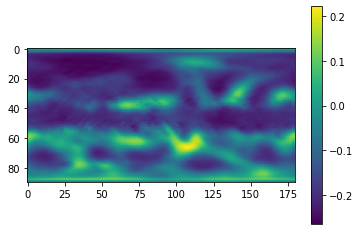

<tf.Tensor: shape=(), dtype=float32, numpy=0.29880086>

In [49]:
output = my_model.call(my_model.input_data[0:1])
plt.figure()
plt.imshow(output.numpy()[0,:,:,0])
plt.colorbar()
plt.show()

my_model.get_loss(my_model.input_data[0:1],my_model.output_data[0:1])

In [10]:
my_model.train_model()

Training iteration: 0
tf.Tensor(0.30690098, shape=(), dtype=float32)
tf.Tensor(0.2964816, shape=(), dtype=float32)
tf.Tensor(0.28741866, shape=(), dtype=float32)
tf.Tensor(0.2799519, shape=(), dtype=float32)
tf.Tensor(0.27085915, shape=(), dtype=float32)
tf.Tensor(0.25844568, shape=(), dtype=float32)
tf.Tensor(0.24823296, shape=(), dtype=float32)
tf.Tensor(0.24032515, shape=(), dtype=float32)
tf.Tensor(0.23116478, shape=(), dtype=float32)
tf.Tensor(0.21701549, shape=(), dtype=float32)
tf.Tensor(0.2109544, shape=(), dtype=float32)
tf.Tensor(0.20581329, shape=(), dtype=float32)
tf.Tensor(0.19712597, shape=(), dtype=float32)
tf.Tensor(0.18983339, shape=(), dtype=float32)
tf.Tensor(0.18334736, shape=(), dtype=float32)
tf.Tensor(0.17298661, shape=(), dtype=float32)
tf.Tensor(0.16306634, shape=(), dtype=float32)
tf.Tensor(0.15543428, shape=(), dtype=float32)
tf.Tensor(0.14801276, shape=(), dtype=float32)
tf.Tensor(0.13476932, shape=(), dtype=float32)
tf.Tensor(0.11875162, shape=(), dtype=flo

tf.Tensor(0.0061876425, shape=(), dtype=float32)
tf.Tensor(0.006160744, shape=(), dtype=float32)
tf.Tensor(0.005858566, shape=(), dtype=float32)
tf.Tensor(0.0053885155, shape=(), dtype=float32)
tf.Tensor(0.004781539, shape=(), dtype=float32)
tf.Tensor(0.0043250704, shape=(), dtype=float32)
tf.Tensor(0.0034604196, shape=(), dtype=float32)
tf.Tensor(0.003426537, shape=(), dtype=float32)
tf.Tensor(0.0042256922, shape=(), dtype=float32)
tf.Tensor(0.004106396, shape=(), dtype=float32)
tf.Tensor(0.0051608947, shape=(), dtype=float32)
tf.Tensor(0.006222107, shape=(), dtype=float32)
tf.Tensor(0.007494832, shape=(), dtype=float32)
tf.Tensor(0.0071803513, shape=(), dtype=float32)
tf.Tensor(0.006848716, shape=(), dtype=float32)
tf.Tensor(0.0067830835, shape=(), dtype=float32)
tf.Tensor(0.0069902646, shape=(), dtype=float32)
tf.Tensor(0.0067790453, shape=(), dtype=float32)
tf.Tensor(0.006771439, shape=(), dtype=float32)
tf.Tensor(0.0060908385, shape=(), dtype=float32)
tf.Tensor(0.005753156, shape=

tf.Tensor(0.003048599, shape=(), dtype=float32)
tf.Tensor(0.0032046714, shape=(), dtype=float32)
tf.Tensor(0.0030702562, shape=(), dtype=float32)
tf.Tensor(0.003140116, shape=(), dtype=float32)
tf.Tensor(0.0033189345, shape=(), dtype=float32)
tf.Tensor(0.0032733383, shape=(), dtype=float32)
tf.Tensor(0.0032082845, shape=(), dtype=float32)
tf.Tensor(0.003078891, shape=(), dtype=float32)
tf.Tensor(0.0030021204, shape=(), dtype=float32)
tf.Tensor(0.0032699602, shape=(), dtype=float32)
tf.Tensor(0.0035107238, shape=(), dtype=float32)
tf.Tensor(0.0040670573, shape=(), dtype=float32)
tf.Tensor(0.0046026176, shape=(), dtype=float32)
tf.Tensor(0.0042892043, shape=(), dtype=float32)
tf.Tensor(0.00459905, shape=(), dtype=float32)
tf.Tensor(0.003664815, shape=(), dtype=float32)
tf.Tensor(0.003471508, shape=(), dtype=float32)
tf.Tensor(0.0031375277, shape=(), dtype=float32)
tf.Tensor(0.0028262103, shape=(), dtype=float32)
tf.Tensor(0.0025976629, shape=(), dtype=float32)
tf.Tensor(0.0025281638, sha

tf.Tensor(0.0036109022, shape=(), dtype=float32)
tf.Tensor(0.00299742, shape=(), dtype=float32)
tf.Tensor(0.002862726, shape=(), dtype=float32)
tf.Tensor(0.003281967, shape=(), dtype=float32)
tf.Tensor(0.0032782413, shape=(), dtype=float32)
tf.Tensor(0.0032677713, shape=(), dtype=float32)
tf.Tensor(0.0034491115, shape=(), dtype=float32)
tf.Tensor(0.003585658, shape=(), dtype=float32)
tf.Tensor(0.0028715536, shape=(), dtype=float32)
tf.Tensor(0.002881372, shape=(), dtype=float32)
tf.Tensor(0.0027774284, shape=(), dtype=float32)
tf.Tensor(0.0027030567, shape=(), dtype=float32)
tf.Tensor(0.0034227534, shape=(), dtype=float32)
tf.Tensor(0.0034530845, shape=(), dtype=float32)
tf.Tensor(0.0032875352, shape=(), dtype=float32)
tf.Tensor(0.0034423077, shape=(), dtype=float32)
tf.Tensor(0.0033860542, shape=(), dtype=float32)
tf.Tensor(0.0029550877, shape=(), dtype=float32)
tf.Tensor(0.0029621518, shape=(), dtype=float32)
tf.Tensor(0.003002383, shape=(), dtype=float32)
tf.Tensor(0.0029359236, sha

tf.Tensor(0.0023614203, shape=(), dtype=float32)
tf.Tensor(0.0025951841, shape=(), dtype=float32)
tf.Tensor(0.0024626288, shape=(), dtype=float32)
tf.Tensor(0.0023890159, shape=(), dtype=float32)
tf.Tensor(0.0024262776, shape=(), dtype=float32)
tf.Tensor(0.0025843696, shape=(), dtype=float32)
tf.Tensor(0.0024668954, shape=(), dtype=float32)
tf.Tensor(0.002459225, shape=(), dtype=float32)
tf.Tensor(0.0028361965, shape=(), dtype=float32)
tf.Tensor(0.0025714766, shape=(), dtype=float32)
tf.Tensor(0.0022081418, shape=(), dtype=float32)
tf.Tensor(0.0022784648, shape=(), dtype=float32)
tf.Tensor(0.0023916955, shape=(), dtype=float32)
tf.Tensor(0.0024733285, shape=(), dtype=float32)
tf.Tensor(0.002483237, shape=(), dtype=float32)
tf.Tensor(0.002456464, shape=(), dtype=float32)
tf.Tensor(0.0025660915, shape=(), dtype=float32)
tf.Tensor(0.0026069076, shape=(), dtype=float32)
tf.Tensor(0.0024979657, shape=(), dtype=float32)
tf.Tensor(0.002625487, shape=(), dtype=float32)
tf.Tensor(0.002567984, s

tf.Tensor(0.0023904352, shape=(), dtype=float32)
tf.Tensor(0.0021201866, shape=(), dtype=float32)
tf.Tensor(0.002251544, shape=(), dtype=float32)
tf.Tensor(0.002624966, shape=(), dtype=float32)
tf.Tensor(0.0030450793, shape=(), dtype=float32)
tf.Tensor(0.0031410267, shape=(), dtype=float32)
tf.Tensor(0.0034168868, shape=(), dtype=float32)
tf.Tensor(0.0030732187, shape=(), dtype=float32)
tf.Tensor(0.003358978, shape=(), dtype=float32)
tf.Tensor(0.0034038946, shape=(), dtype=float32)
tf.Tensor(0.0030055454, shape=(), dtype=float32)
tf.Tensor(0.0023059552, shape=(), dtype=float32)
tf.Tensor(0.0023929982, shape=(), dtype=float32)
tf.Tensor(0.0024349105, shape=(), dtype=float32)
tf.Tensor(0.002269079, shape=(), dtype=float32)
tf.Tensor(0.0027068784, shape=(), dtype=float32)
tf.Tensor(0.0033388834, shape=(), dtype=float32)
tf.Tensor(0.0029412026, shape=(), dtype=float32)
tf.Tensor(0.0026739996, shape=(), dtype=float32)
tf.Tensor(0.0023854366, shape=(), dtype=float32)
tf.Tensor(0.0020726398, 

tf.Tensor(0.004598, shape=(), dtype=float32)
tf.Tensor(0.0037670976, shape=(), dtype=float32)
tf.Tensor(0.0029012687, shape=(), dtype=float32)
tf.Tensor(0.002572144, shape=(), dtype=float32)
tf.Tensor(0.002217664, shape=(), dtype=float32)
tf.Tensor(0.0029491715, shape=(), dtype=float32)
tf.Tensor(0.0032125814, shape=(), dtype=float32)
tf.Tensor(0.0031496836, shape=(), dtype=float32)
tf.Tensor(0.0032663322, shape=(), dtype=float32)
tf.Tensor(0.0025950214, shape=(), dtype=float32)
tf.Tensor(0.0024807237, shape=(), dtype=float32)
tf.Tensor(0.0021728917, shape=(), dtype=float32)
tf.Tensor(0.00281233, shape=(), dtype=float32)
tf.Tensor(0.00240382, shape=(), dtype=float32)
tf.Tensor(0.0025913997, shape=(), dtype=float32)
tf.Tensor(0.0032213347, shape=(), dtype=float32)
tf.Tensor(0.0024279228, shape=(), dtype=float32)
tf.Tensor(0.0020153264, shape=(), dtype=float32)
tf.Tensor(0.0020401361, shape=(), dtype=float32)
tf.Tensor(0.0023427254, shape=(), dtype=float32)
tf.Tensor(0.002195427, shape=(

tf.Tensor(0.002733895, shape=(), dtype=float32)
tf.Tensor(0.002450562, shape=(), dtype=float32)
tf.Tensor(0.0023050818, shape=(), dtype=float32)
tf.Tensor(0.0023556966, shape=(), dtype=float32)
tf.Tensor(0.0024994838, shape=(), dtype=float32)
tf.Tensor(0.0022371954, shape=(), dtype=float32)
tf.Tensor(0.001993993, shape=(), dtype=float32)
tf.Tensor(0.0017900463, shape=(), dtype=float32)
tf.Tensor(0.0016577876, shape=(), dtype=float32)
tf.Tensor(0.001705213, shape=(), dtype=float32)
tf.Tensor(0.0019831313, shape=(), dtype=float32)
tf.Tensor(0.0019081197, shape=(), dtype=float32)
tf.Tensor(0.0017264577, shape=(), dtype=float32)
tf.Tensor(0.0018387804, shape=(), dtype=float32)
tf.Tensor(0.002101961, shape=(), dtype=float32)
tf.Tensor(0.0032973706, shape=(), dtype=float32)
tf.Tensor(0.004655671, shape=(), dtype=float32)
tf.Tensor(0.0041536074, shape=(), dtype=float32)
tf.Tensor(0.0030516956, shape=(), dtype=float32)
tf.Tensor(0.0032224464, shape=(), dtype=float32)
tf.Tensor(0.0030189028, sh

tf.Tensor(0.0017676976, shape=(), dtype=float32)
tf.Tensor(0.0016003908, shape=(), dtype=float32)
tf.Tensor(0.0017346499, shape=(), dtype=float32)
tf.Tensor(0.0020270813, shape=(), dtype=float32)
tf.Tensor(0.0018568938, shape=(), dtype=float32)
tf.Tensor(0.0016792142, shape=(), dtype=float32)
tf.Tensor(0.0017252413, shape=(), dtype=float32)
tf.Tensor(0.001988238, shape=(), dtype=float32)
tf.Tensor(0.0018146323, shape=(), dtype=float32)
tf.Tensor(0.0017591215, shape=(), dtype=float32)
tf.Tensor(0.00181014, shape=(), dtype=float32)
tf.Tensor(0.0016320468, shape=(), dtype=float32)
tf.Tensor(0.0015582511, shape=(), dtype=float32)
tf.Tensor(0.001692469, shape=(), dtype=float32)
tf.Tensor(0.0017971897, shape=(), dtype=float32)
tf.Tensor(0.0020477904, shape=(), dtype=float32)
tf.Tensor(0.0021754794, shape=(), dtype=float32)
tf.Tensor(0.00227363, shape=(), dtype=float32)
tf.Tensor(0.002299969, shape=(), dtype=float32)
tf.Tensor(0.0018125417, shape=(), dtype=float32)
tf.Tensor(0.0017018248, sha

tf.Tensor(0.0022397614, shape=(), dtype=float32)
tf.Tensor(0.0017092724, shape=(), dtype=float32)
tf.Tensor(0.0015713476, shape=(), dtype=float32)
tf.Tensor(0.0018530985, shape=(), dtype=float32)
tf.Tensor(0.0018039669, shape=(), dtype=float32)
tf.Tensor(0.0016777192, shape=(), dtype=float32)
tf.Tensor(0.0015545214, shape=(), dtype=float32)
tf.Tensor(0.0018367546, shape=(), dtype=float32)
tf.Tensor(0.0018405893, shape=(), dtype=float32)
tf.Tensor(0.0020856673, shape=(), dtype=float32)
tf.Tensor(0.0020011964, shape=(), dtype=float32)
tf.Tensor(0.0017038907, shape=(), dtype=float32)
tf.Tensor(0.0017580152, shape=(), dtype=float32)
tf.Tensor(0.0017571702, shape=(), dtype=float32)
tf.Tensor(0.001572678, shape=(), dtype=float32)
tf.Tensor(0.0017028836, shape=(), dtype=float32)
tf.Tensor(0.0016441466, shape=(), dtype=float32)
tf.Tensor(0.0015984833, shape=(), dtype=float32)
tf.Tensor(0.001616849, shape=(), dtype=float32)
tf.Tensor(0.001518121, shape=(), dtype=float32)
tf.Tensor(0.0017155864,

tf.Tensor(0.0015721059, shape=(), dtype=float32)
tf.Tensor(0.0014477608, shape=(), dtype=float32)
tf.Tensor(0.001564705, shape=(), dtype=float32)
tf.Tensor(0.0015168772, shape=(), dtype=float32)
tf.Tensor(0.0017958876, shape=(), dtype=float32)
tf.Tensor(0.0019286321, shape=(), dtype=float32)
tf.Tensor(0.0022010582, shape=(), dtype=float32)
tf.Tensor(0.002334812, shape=(), dtype=float32)
tf.Tensor(0.0017758236, shape=(), dtype=float32)
tf.Tensor(0.0016525137, shape=(), dtype=float32)
tf.Tensor(0.0017031468, shape=(), dtype=float32)
tf.Tensor(0.0014650412, shape=(), dtype=float32)
tf.Tensor(0.001474073, shape=(), dtype=float32)
tf.Tensor(0.0014297252, shape=(), dtype=float32)
tf.Tensor(0.0015199136, shape=(), dtype=float32)
tf.Tensor(0.0015631126, shape=(), dtype=float32)
tf.Tensor(0.0015137532, shape=(), dtype=float32)
tf.Tensor(0.0018001768, shape=(), dtype=float32)
tf.Tensor(0.0019058688, shape=(), dtype=float32)
tf.Tensor(0.001979032, shape=(), dtype=float32)
tf.Tensor(0.0018538347, 

tf.Tensor(0.0016923, shape=(), dtype=float32)
tf.Tensor(0.0018819435, shape=(), dtype=float32)
tf.Tensor(0.0021325867, shape=(), dtype=float32)
tf.Tensor(0.0021356551, shape=(), dtype=float32)
tf.Tensor(0.0026537594, shape=(), dtype=float32)
tf.Tensor(0.002228824, shape=(), dtype=float32)
tf.Tensor(0.0018328475, shape=(), dtype=float32)
tf.Tensor(0.0014857963, shape=(), dtype=float32)
tf.Tensor(0.0014150671, shape=(), dtype=float32)
tf.Tensor(0.0015008907, shape=(), dtype=float32)
tf.Tensor(0.0016323682, shape=(), dtype=float32)
tf.Tensor(0.0018594279, shape=(), dtype=float32)
tf.Tensor(0.00155433, shape=(), dtype=float32)
tf.Tensor(0.0017824159, shape=(), dtype=float32)
tf.Tensor(0.0023084832, shape=(), dtype=float32)
tf.Tensor(0.002725095, shape=(), dtype=float32)
tf.Tensor(0.0026941507, shape=(), dtype=float32)
tf.Tensor(0.0024945708, shape=(), dtype=float32)
tf.Tensor(0.0023085738, shape=(), dtype=float32)
tf.Tensor(0.002409242, shape=(), dtype=float32)
tf.Tensor(0.0022568274, shap

tf.Tensor(0.001660489, shape=(), dtype=float32)
tf.Tensor(0.0015089808, shape=(), dtype=float32)
tf.Tensor(0.001315176, shape=(), dtype=float32)
tf.Tensor(0.0013223126, shape=(), dtype=float32)
tf.Tensor(0.0012257866, shape=(), dtype=float32)
tf.Tensor(0.0013391011, shape=(), dtype=float32)
tf.Tensor(0.0013623392, shape=(), dtype=float32)
tf.Tensor(0.0015718306, shape=(), dtype=float32)
tf.Tensor(0.001480497, shape=(), dtype=float32)
tf.Tensor(0.0015467852, shape=(), dtype=float32)
tf.Tensor(0.0015448937, shape=(), dtype=float32)
tf.Tensor(0.0013173956, shape=(), dtype=float32)
tf.Tensor(0.0012129444, shape=(), dtype=float32)
tf.Tensor(0.0013096198, shape=(), dtype=float32)
tf.Tensor(0.0012675639, shape=(), dtype=float32)
tf.Tensor(0.0013166739, shape=(), dtype=float32)
tf.Tensor(0.0013536165, shape=(), dtype=float32)
tf.Tensor(0.0014489389, shape=(), dtype=float32)
tf.Tensor(0.0013270383, shape=(), dtype=float32)
tf.Tensor(0.0012839901, shape=(), dtype=float32)
tf.Tensor(0.0015387319,

tf.Tensor(0.0026808435, shape=(), dtype=float32)
tf.Tensor(0.0019489636, shape=(), dtype=float32)
tf.Tensor(0.0014151264, shape=(), dtype=float32)
tf.Tensor(0.0016344931, shape=(), dtype=float32)
tf.Tensor(0.002274752, shape=(), dtype=float32)
tf.Tensor(0.0022954815, shape=(), dtype=float32)
tf.Tensor(0.0020036343, shape=(), dtype=float32)
tf.Tensor(0.001900177, shape=(), dtype=float32)
tf.Tensor(0.001577607, shape=(), dtype=float32)
tf.Tensor(0.0014704054, shape=(), dtype=float32)
tf.Tensor(0.0014650769, shape=(), dtype=float32)
tf.Tensor(0.0015670242, shape=(), dtype=float32)
tf.Tensor(0.0016282354, shape=(), dtype=float32)
tf.Tensor(0.0018286274, shape=(), dtype=float32)
tf.Tensor(0.0017685067, shape=(), dtype=float32)
tf.Tensor(0.0020407706, shape=(), dtype=float32)
tf.Tensor(0.0030293204, shape=(), dtype=float32)
tf.Tensor(0.0026842654, shape=(), dtype=float32)
tf.Tensor(0.002553243, shape=(), dtype=float32)
tf.Tensor(0.002391489, shape=(), dtype=float32)
tf.Tensor(0.0022910761, s

tf.Tensor(0.002449874, shape=(), dtype=float32)
tf.Tensor(0.0018780988, shape=(), dtype=float32)
tf.Tensor(0.0017513413, shape=(), dtype=float32)
tf.Tensor(0.0016451015, shape=(), dtype=float32)
tf.Tensor(0.001497062, shape=(), dtype=float32)
tf.Tensor(0.0014747118, shape=(), dtype=float32)
tf.Tensor(0.0016633141, shape=(), dtype=float32)
tf.Tensor(0.0018217675, shape=(), dtype=float32)
tf.Tensor(0.002110372, shape=(), dtype=float32)
tf.Tensor(0.0017564595, shape=(), dtype=float32)
tf.Tensor(0.0014284502, shape=(), dtype=float32)
tf.Tensor(0.0011923196, shape=(), dtype=float32)
tf.Tensor(0.0012677836, shape=(), dtype=float32)
tf.Tensor(0.0012340277, shape=(), dtype=float32)
tf.Tensor(0.0011071155, shape=(), dtype=float32)
tf.Tensor(0.0011377393, shape=(), dtype=float32)
tf.Tensor(0.001161248, shape=(), dtype=float32)
tf.Tensor(0.0013687895, shape=(), dtype=float32)
tf.Tensor(0.0013754214, shape=(), dtype=float32)
tf.Tensor(0.0014076206, shape=(), dtype=float32)
tf.Tensor(0.0013626653, 

tf.Tensor(0.001875275, shape=(), dtype=float32)
tf.Tensor(0.0016136053, shape=(), dtype=float32)
tf.Tensor(0.0015090546, shape=(), dtype=float32)
tf.Tensor(0.0015842195, shape=(), dtype=float32)
tf.Tensor(0.0017341069, shape=(), dtype=float32)
tf.Tensor(0.0014674211, shape=(), dtype=float32)
tf.Tensor(0.0011577774, shape=(), dtype=float32)
tf.Tensor(0.0010576027, shape=(), dtype=float32)
tf.Tensor(0.0010475328, shape=(), dtype=float32)
tf.Tensor(0.0011392778, shape=(), dtype=float32)
tf.Tensor(0.0011605056, shape=(), dtype=float32)
tf.Tensor(0.0012644136, shape=(), dtype=float32)
tf.Tensor(0.0012243509, shape=(), dtype=float32)
tf.Tensor(0.0010965364, shape=(), dtype=float32)
tf.Tensor(0.001135169, shape=(), dtype=float32)
tf.Tensor(0.0012585555, shape=(), dtype=float32)
tf.Tensor(0.0011960532, shape=(), dtype=float32)
tf.Tensor(0.0010895942, shape=(), dtype=float32)
tf.Tensor(0.0011724231, shape=(), dtype=float32)
tf.Tensor(0.0016389487, shape=(), dtype=float32)
tf.Tensor(0.0016481727

tf.Tensor(0.0016439625, shape=(), dtype=float32)
tf.Tensor(0.0015874854, shape=(), dtype=float32)
tf.Tensor(0.0016188532, shape=(), dtype=float32)
tf.Tensor(0.0013912267, shape=(), dtype=float32)
tf.Tensor(0.0012863725, shape=(), dtype=float32)
tf.Tensor(0.0011230718, shape=(), dtype=float32)
tf.Tensor(0.0012037988, shape=(), dtype=float32)
tf.Tensor(0.0011822726, shape=(), dtype=float32)
tf.Tensor(0.0012046985, shape=(), dtype=float32)
tf.Tensor(0.0012784355, shape=(), dtype=float32)
tf.Tensor(0.001208172, shape=(), dtype=float32)
tf.Tensor(0.001116485, shape=(), dtype=float32)
tf.Tensor(0.0012540079, shape=(), dtype=float32)
tf.Tensor(0.0011881434, shape=(), dtype=float32)
tf.Tensor(0.0013052694, shape=(), dtype=float32)
tf.Tensor(0.0015843479, shape=(), dtype=float32)
tf.Tensor(0.0016593987, shape=(), dtype=float32)
tf.Tensor(0.001383938, shape=(), dtype=float32)
tf.Tensor(0.0012764136, shape=(), dtype=float32)
tf.Tensor(0.0014378832, shape=(), dtype=float32)
tf.Tensor(0.0013386181,

tf.Tensor(0.0011395663, shape=(), dtype=float32)
tf.Tensor(0.0012268126, shape=(), dtype=float32)
tf.Tensor(0.0011858855, shape=(), dtype=float32)
tf.Tensor(0.001214309, shape=(), dtype=float32)
tf.Tensor(0.0013220469, shape=(), dtype=float32)
tf.Tensor(0.0013786933, shape=(), dtype=float32)
tf.Tensor(0.0011953551, shape=(), dtype=float32)
tf.Tensor(0.001280542, shape=(), dtype=float32)
tf.Tensor(0.001266273, shape=(), dtype=float32)
tf.Tensor(0.0012118574, shape=(), dtype=float32)
tf.Tensor(0.0011714634, shape=(), dtype=float32)
tf.Tensor(0.0012298083, shape=(), dtype=float32)
tf.Tensor(0.0012768569, shape=(), dtype=float32)
tf.Tensor(0.0011564249, shape=(), dtype=float32)
tf.Tensor(0.0012475133, shape=(), dtype=float32)
tf.Tensor(0.0011100637, shape=(), dtype=float32)
tf.Tensor(0.0009794054, shape=(), dtype=float32)
tf.Tensor(0.00094548444, shape=(), dtype=float32)
tf.Tensor(0.0010325619, shape=(), dtype=float32)
tf.Tensor(0.001191295, shape=(), dtype=float32)
tf.Tensor(0.0011264433,

tf.Tensor(0.0017869412, shape=(), dtype=float32)
tf.Tensor(0.0019152048, shape=(), dtype=float32)
tf.Tensor(0.0017393015, shape=(), dtype=float32)
tf.Tensor(0.0013513535, shape=(), dtype=float32)
tf.Tensor(0.0012479303, shape=(), dtype=float32)
tf.Tensor(0.0011974676, shape=(), dtype=float32)
tf.Tensor(0.0013172987, shape=(), dtype=float32)
tf.Tensor(0.0014844554, shape=(), dtype=float32)
tf.Tensor(0.001414308, shape=(), dtype=float32)
tf.Tensor(0.001400735, shape=(), dtype=float32)
tf.Tensor(0.0013909367, shape=(), dtype=float32)
tf.Tensor(0.0012710715, shape=(), dtype=float32)
tf.Tensor(0.001235529, shape=(), dtype=float32)
tf.Tensor(0.0012720787, shape=(), dtype=float32)
tf.Tensor(0.0012205408, shape=(), dtype=float32)
tf.Tensor(0.0012151425, shape=(), dtype=float32)
tf.Tensor(0.0012670826, shape=(), dtype=float32)
tf.Tensor(0.0013942202, shape=(), dtype=float32)
tf.Tensor(0.0013960892, shape=(), dtype=float32)
tf.Tensor(0.001366887, shape=(), dtype=float32)
tf.Tensor(0.0015631311, 

tf.Tensor(0.0011244647, shape=(), dtype=float32)
tf.Tensor(0.0012277722, shape=(), dtype=float32)
tf.Tensor(0.0011888992, shape=(), dtype=float32)
tf.Tensor(0.0013853735, shape=(), dtype=float32)
tf.Tensor(0.0013294523, shape=(), dtype=float32)
tf.Tensor(0.0014467958, shape=(), dtype=float32)
tf.Tensor(0.0015545633, shape=(), dtype=float32)
tf.Tensor(0.0016558162, shape=(), dtype=float32)
tf.Tensor(0.0017313544, shape=(), dtype=float32)
tf.Tensor(0.0013816799, shape=(), dtype=float32)
tf.Tensor(0.0014140167, shape=(), dtype=float32)
tf.Tensor(0.0012848432, shape=(), dtype=float32)
tf.Tensor(0.0012466181, shape=(), dtype=float32)
tf.Tensor(0.0011592067, shape=(), dtype=float32)
tf.Tensor(0.0011846357, shape=(), dtype=float32)
tf.Tensor(0.0011197344, shape=(), dtype=float32)
tf.Tensor(0.0011158463, shape=(), dtype=float32)
tf.Tensor(0.0012530219, shape=(), dtype=float32)
tf.Tensor(0.0012527857, shape=(), dtype=float32)
tf.Tensor(0.0013414036, shape=(), dtype=float32)
tf.Tensor(0.00121838

tf.Tensor(0.0011989637, shape=(), dtype=float32)
tf.Tensor(0.0012464258, shape=(), dtype=float32)
tf.Tensor(0.0012017738, shape=(), dtype=float32)
tf.Tensor(0.001229632, shape=(), dtype=float32)
tf.Tensor(0.0010628933, shape=(), dtype=float32)
tf.Tensor(0.0010636129, shape=(), dtype=float32)
tf.Tensor(0.0011756682, shape=(), dtype=float32)
tf.Tensor(0.0010787626, shape=(), dtype=float32)
tf.Tensor(0.0010873565, shape=(), dtype=float32)
tf.Tensor(0.0012859491, shape=(), dtype=float32)
tf.Tensor(0.0013971342, shape=(), dtype=float32)
tf.Tensor(0.001507615, shape=(), dtype=float32)
tf.Tensor(0.0015946464, shape=(), dtype=float32)
tf.Tensor(0.0016629554, shape=(), dtype=float32)
tf.Tensor(0.0016475731, shape=(), dtype=float32)
tf.Tensor(0.0014972335, shape=(), dtype=float32)
tf.Tensor(0.0019866135, shape=(), dtype=float32)
tf.Tensor(0.0016370446, shape=(), dtype=float32)
tf.Tensor(0.001381272, shape=(), dtype=float32)
tf.Tensor(0.0012681138, shape=(), dtype=float32)
tf.Tensor(0.0013139715,

tf.Tensor(0.0013337138, shape=(), dtype=float32)
tf.Tensor(0.0011642784, shape=(), dtype=float32)
tf.Tensor(0.0011046922, shape=(), dtype=float32)
tf.Tensor(0.001019558, shape=(), dtype=float32)
tf.Tensor(0.0010706875, shape=(), dtype=float32)
tf.Tensor(0.0011502953, shape=(), dtype=float32)
tf.Tensor(0.0011717421, shape=(), dtype=float32)
tf.Tensor(0.0012255835, shape=(), dtype=float32)
tf.Tensor(0.001477572, shape=(), dtype=float32)
tf.Tensor(0.0017143677, shape=(), dtype=float32)
tf.Tensor(0.0018497969, shape=(), dtype=float32)
tf.Tensor(0.0021065308, shape=(), dtype=float32)
tf.Tensor(0.001501727, shape=(), dtype=float32)
tf.Tensor(0.001391409, shape=(), dtype=float32)
tf.Tensor(0.0012692196, shape=(), dtype=float32)
tf.Tensor(0.0014198896, shape=(), dtype=float32)
tf.Tensor(0.0013275254, shape=(), dtype=float32)
tf.Tensor(0.0012407182, shape=(), dtype=float32)
tf.Tensor(0.001184118, shape=(), dtype=float32)
tf.Tensor(0.0013205315, shape=(), dtype=float32)
tf.Tensor(0.0014565898, s

tf.Tensor(0.0014062957, shape=(), dtype=float32)
tf.Tensor(0.0013298551, shape=(), dtype=float32)
tf.Tensor(0.0013804341, shape=(), dtype=float32)
tf.Tensor(0.0013875228, shape=(), dtype=float32)
tf.Tensor(0.0013993651, shape=(), dtype=float32)
tf.Tensor(0.0015446143, shape=(), dtype=float32)
tf.Tensor(0.0013265426, shape=(), dtype=float32)
tf.Tensor(0.0014747997, shape=(), dtype=float32)
tf.Tensor(0.0013538594, shape=(), dtype=float32)
tf.Tensor(0.0013397394, shape=(), dtype=float32)
tf.Tensor(0.0011727613, shape=(), dtype=float32)
tf.Tensor(0.0012394303, shape=(), dtype=float32)
tf.Tensor(0.0012750601, shape=(), dtype=float32)
tf.Tensor(0.0012077657, shape=(), dtype=float32)
tf.Tensor(0.001283387, shape=(), dtype=float32)
tf.Tensor(0.0010933025, shape=(), dtype=float32)
tf.Tensor(0.0010155493, shape=(), dtype=float32)
tf.Tensor(0.0010571713, shape=(), dtype=float32)
tf.Tensor(0.0012770843, shape=(), dtype=float32)
tf.Tensor(0.001291881, shape=(), dtype=float32)
tf.Tensor(0.0013424972

tf.Tensor(0.001058781, shape=(), dtype=float32)
tf.Tensor(0.000993471, shape=(), dtype=float32)
tf.Tensor(0.0010706212, shape=(), dtype=float32)
tf.Tensor(0.0011262026, shape=(), dtype=float32)
tf.Tensor(0.0011364584, shape=(), dtype=float32)
tf.Tensor(0.0012566041, shape=(), dtype=float32)
tf.Tensor(0.0013672394, shape=(), dtype=float32)
tf.Tensor(0.0011518839, shape=(), dtype=float32)
tf.Tensor(0.0010458785, shape=(), dtype=float32)
tf.Tensor(0.0010672238, shape=(), dtype=float32)
tf.Tensor(0.0010937217, shape=(), dtype=float32)
tf.Tensor(0.0012503226, shape=(), dtype=float32)
tf.Tensor(0.0015588049, shape=(), dtype=float32)
tf.Tensor(0.0014469416, shape=(), dtype=float32)
tf.Tensor(0.0015938337, shape=(), dtype=float32)
tf.Tensor(0.0015578876, shape=(), dtype=float32)
tf.Tensor(0.0017624166, shape=(), dtype=float32)
tf.Tensor(0.0016162309, shape=(), dtype=float32)
tf.Tensor(0.0014010252, shape=(), dtype=float32)
tf.Tensor(0.0013510674, shape=(), dtype=float32)
tf.Tensor(0.001267316,

tf.Tensor(0.0011657231, shape=(), dtype=float32)
tf.Tensor(0.0010818255, shape=(), dtype=float32)
tf.Tensor(0.0010190919, shape=(), dtype=float32)
tf.Tensor(0.001255227, shape=(), dtype=float32)
tf.Tensor(0.0013344757, shape=(), dtype=float32)
tf.Tensor(0.0014564019, shape=(), dtype=float32)
tf.Tensor(0.0013720432, shape=(), dtype=float32)
tf.Tensor(0.0013257308, shape=(), dtype=float32)
tf.Tensor(0.0012515683, shape=(), dtype=float32)
tf.Tensor(0.0011239203, shape=(), dtype=float32)
tf.Tensor(0.001087964, shape=(), dtype=float32)
tf.Tensor(0.0010151288, shape=(), dtype=float32)
tf.Tensor(0.0010633896, shape=(), dtype=float32)
tf.Tensor(0.0010444073, shape=(), dtype=float32)
tf.Tensor(0.000994994, shape=(), dtype=float32)
tf.Tensor(0.0010562155, shape=(), dtype=float32)
tf.Tensor(0.0010558546, shape=(), dtype=float32)
tf.Tensor(0.0012724338, shape=(), dtype=float32)
tf.Tensor(0.0014111596, shape=(), dtype=float32)
tf.Tensor(0.0013818186, shape=(), dtype=float32)
tf.Tensor(0.0013528869,

tf.Tensor(0.0011380627, shape=(), dtype=float32)
tf.Tensor(0.0011492216, shape=(), dtype=float32)
tf.Tensor(0.0011203517, shape=(), dtype=float32)
tf.Tensor(0.0012222974, shape=(), dtype=float32)
tf.Tensor(0.0011759313, shape=(), dtype=float32)
tf.Tensor(0.0011496025, shape=(), dtype=float32)
tf.Tensor(0.001013356, shape=(), dtype=float32)
tf.Tensor(0.0013146081, shape=(), dtype=float32)
tf.Tensor(0.0011043195, shape=(), dtype=float32)
tf.Tensor(0.0011642146, shape=(), dtype=float32)
tf.Tensor(0.0011968291, shape=(), dtype=float32)
tf.Tensor(0.0012048244, shape=(), dtype=float32)
tf.Tensor(0.0012449865, shape=(), dtype=float32)
tf.Tensor(0.0012605464, shape=(), dtype=float32)
tf.Tensor(0.0012032464, shape=(), dtype=float32)
tf.Tensor(0.0011286751, shape=(), dtype=float32)
tf.Tensor(0.0010480252, shape=(), dtype=float32)
tf.Tensor(0.0010611682, shape=(), dtype=float32)
tf.Tensor(0.0011488944, shape=(), dtype=float32)
tf.Tensor(0.0011773088, shape=(), dtype=float32)
tf.Tensor(0.001324899

tf.Tensor(0.0011378208, shape=(), dtype=float32)
tf.Tensor(0.0010658616, shape=(), dtype=float32)
tf.Tensor(0.0010756782, shape=(), dtype=float32)
tf.Tensor(0.0011762757, shape=(), dtype=float32)
tf.Tensor(0.0011376148, shape=(), dtype=float32)
tf.Tensor(0.0011427822, shape=(), dtype=float32)
tf.Tensor(0.0011370744, shape=(), dtype=float32)
tf.Tensor(0.0010566738, shape=(), dtype=float32)
tf.Tensor(0.00094701035, shape=(), dtype=float32)
tf.Tensor(0.00106608, shape=(), dtype=float32)
tf.Tensor(0.0010965018, shape=(), dtype=float32)
tf.Tensor(0.001097378, shape=(), dtype=float32)
tf.Tensor(0.0011465317, shape=(), dtype=float32)
tf.Tensor(0.0010665187, shape=(), dtype=float32)
tf.Tensor(0.0009202963, shape=(), dtype=float32)
tf.Tensor(0.0011075932, shape=(), dtype=float32)
tf.Tensor(0.0011424427, shape=(), dtype=float32)
tf.Tensor(0.0013181656, shape=(), dtype=float32)
tf.Tensor(0.0014126058, shape=(), dtype=float32)
tf.Tensor(0.001340156, shape=(), dtype=float32)
tf.Tensor(0.0013201215,

tf.Tensor(0.00095004693, shape=(), dtype=float32)
tf.Tensor(0.0011793855, shape=(), dtype=float32)
tf.Tensor(0.001156026, shape=(), dtype=float32)
tf.Tensor(0.00096866227, shape=(), dtype=float32)
tf.Tensor(0.0010848838, shape=(), dtype=float32)
tf.Tensor(0.001354477, shape=(), dtype=float32)
tf.Tensor(0.0010897293, shape=(), dtype=float32)
tf.Tensor(0.0010469938, shape=(), dtype=float32)
tf.Tensor(0.0012139027, shape=(), dtype=float32)
tf.Tensor(0.001219943, shape=(), dtype=float32)
tf.Tensor(0.0011269293, shape=(), dtype=float32)
tf.Tensor(0.0011429737, shape=(), dtype=float32)
tf.Tensor(0.0011366007, shape=(), dtype=float32)
tf.Tensor(0.0013175023, shape=(), dtype=float32)
tf.Tensor(0.001546369, shape=(), dtype=float32)
tf.Tensor(0.0014179412, shape=(), dtype=float32)
tf.Tensor(0.0015201737, shape=(), dtype=float32)
tf.Tensor(0.0013230663, shape=(), dtype=float32)
tf.Tensor(0.0011988484, shape=(), dtype=float32)
tf.Tensor(0.0010677249, shape=(), dtype=float32)
tf.Tensor(0.00112972, 

tf.Tensor(0.0011191515, shape=(), dtype=float32)
tf.Tensor(0.0009926473, shape=(), dtype=float32)
tf.Tensor(0.0009356687, shape=(), dtype=float32)
tf.Tensor(0.0010637821, shape=(), dtype=float32)
tf.Tensor(0.0010555167, shape=(), dtype=float32)
tf.Tensor(0.0009087951, shape=(), dtype=float32)
tf.Tensor(0.00084180647, shape=(), dtype=float32)
tf.Tensor(0.0009652915, shape=(), dtype=float32)
tf.Tensor(0.0010484026, shape=(), dtype=float32)
tf.Tensor(0.0011392196, shape=(), dtype=float32)
tf.Tensor(0.0010447385, shape=(), dtype=float32)
tf.Tensor(0.00096636487, shape=(), dtype=float32)
tf.Tensor(0.00094563863, shape=(), dtype=float32)
tf.Tensor(0.0009833132, shape=(), dtype=float32)
tf.Tensor(0.00091981527, shape=(), dtype=float32)
tf.Tensor(0.0009905534, shape=(), dtype=float32)
tf.Tensor(0.0011453484, shape=(), dtype=float32)
tf.Tensor(0.0012961185, shape=(), dtype=float32)
tf.Tensor(0.0013880285, shape=(), dtype=float32)
tf.Tensor(0.0013812963, shape=(), dtype=float32)
tf.Tensor(0.0012

tf.Tensor(0.0010998463, shape=(), dtype=float32)
tf.Tensor(0.0010789724, shape=(), dtype=float32)
tf.Tensor(0.0011002318, shape=(), dtype=float32)
tf.Tensor(0.0013172698, shape=(), dtype=float32)
tf.Tensor(0.0012545475, shape=(), dtype=float32)
tf.Tensor(0.00116829, shape=(), dtype=float32)
tf.Tensor(0.0011055142, shape=(), dtype=float32)
tf.Tensor(0.0009777083, shape=(), dtype=float32)
tf.Tensor(0.0010615535, shape=(), dtype=float32)
tf.Tensor(0.0011654975, shape=(), dtype=float32)
tf.Tensor(0.0011123025, shape=(), dtype=float32)
tf.Tensor(0.0011386707, shape=(), dtype=float32)
tf.Tensor(0.0011396222, shape=(), dtype=float32)
tf.Tensor(0.0010553261, shape=(), dtype=float32)
tf.Tensor(0.0010597615, shape=(), dtype=float32)
tf.Tensor(0.0010670843, shape=(), dtype=float32)
tf.Tensor(0.0009651532, shape=(), dtype=float32)
tf.Tensor(0.0010255186, shape=(), dtype=float32)
tf.Tensor(0.0010041854, shape=(), dtype=float32)
tf.Tensor(0.0009334934, shape=(), dtype=float32)
tf.Tensor(0.0009947974

tf.Tensor(0.0012108767, shape=(), dtype=float32)
tf.Tensor(0.0011184226, shape=(), dtype=float32)
tf.Tensor(0.001054657, shape=(), dtype=float32)
tf.Tensor(0.0010357402, shape=(), dtype=float32)
tf.Tensor(0.0012010864, shape=(), dtype=float32)
tf.Tensor(0.0012375814, shape=(), dtype=float32)
tf.Tensor(0.0010633575, shape=(), dtype=float32)
tf.Tensor(0.001189089, shape=(), dtype=float32)
tf.Tensor(0.0010774003, shape=(), dtype=float32)
tf.Tensor(0.00091250695, shape=(), dtype=float32)
tf.Tensor(0.00087803096, shape=(), dtype=float32)
tf.Tensor(0.0008486822, shape=(), dtype=float32)
tf.Tensor(0.00085791363, shape=(), dtype=float32)
tf.Tensor(0.0009106566, shape=(), dtype=float32)
tf.Tensor(0.000896846, shape=(), dtype=float32)
tf.Tensor(0.00094454346, shape=(), dtype=float32)
tf.Tensor(0.00096312264, shape=(), dtype=float32)
tf.Tensor(0.0010047897, shape=(), dtype=float32)
tf.Tensor(0.0010088676, shape=(), dtype=float32)
tf.Tensor(0.0011082322, shape=(), dtype=float32)
tf.Tensor(0.001225

tf.Tensor(0.0013033036, shape=(), dtype=float32)
tf.Tensor(0.0015162239, shape=(), dtype=float32)
tf.Tensor(0.001389879, shape=(), dtype=float32)
tf.Tensor(0.0013110903, shape=(), dtype=float32)
tf.Tensor(0.0016833136, shape=(), dtype=float32)
tf.Tensor(0.0014988788, shape=(), dtype=float32)
tf.Tensor(0.0015915304, shape=(), dtype=float32)
tf.Tensor(0.0019554691, shape=(), dtype=float32)
tf.Tensor(0.0014682802, shape=(), dtype=float32)
tf.Tensor(0.0011715781, shape=(), dtype=float32)
tf.Tensor(0.0009437889, shape=(), dtype=float32)
tf.Tensor(0.0009138046, shape=(), dtype=float32)
tf.Tensor(0.00095115125, shape=(), dtype=float32)
tf.Tensor(0.00096955895, shape=(), dtype=float32)
tf.Tensor(0.0008604595, shape=(), dtype=float32)
tf.Tensor(0.00079247484, shape=(), dtype=float32)
tf.Tensor(0.0008333748, shape=(), dtype=float32)
tf.Tensor(0.00083602546, shape=(), dtype=float32)
tf.Tensor(0.0009307432, shape=(), dtype=float32)
tf.Tensor(0.0011574256, shape=(), dtype=float32)
tf.Tensor(0.00143

tf.Tensor(0.00107116, shape=(), dtype=float32)
tf.Tensor(0.0011424519, shape=(), dtype=float32)
tf.Tensor(0.0011531354, shape=(), dtype=float32)
tf.Tensor(0.0011074231, shape=(), dtype=float32)
tf.Tensor(0.0010014682, shape=(), dtype=float32)
tf.Tensor(0.0011094612, shape=(), dtype=float32)
tf.Tensor(0.0012573954, shape=(), dtype=float32)
tf.Tensor(0.0012373927, shape=(), dtype=float32)
tf.Tensor(0.0014863354, shape=(), dtype=float32)
tf.Tensor(0.0013294221, shape=(), dtype=float32)
tf.Tensor(0.0013435473, shape=(), dtype=float32)
tf.Tensor(0.0010564445, shape=(), dtype=float32)
tf.Tensor(0.0010636683, shape=(), dtype=float32)
tf.Tensor(0.0010826965, shape=(), dtype=float32)
tf.Tensor(0.0011293916, shape=(), dtype=float32)
tf.Tensor(0.0009789324, shape=(), dtype=float32)
tf.Tensor(0.00083444803, shape=(), dtype=float32)
tf.Tensor(0.0008869932, shape=(), dtype=float32)
tf.Tensor(0.00084526767, shape=(), dtype=float32)
tf.Tensor(0.00088571134, shape=(), dtype=float32)
tf.Tensor(0.0008985

tf.Tensor(0.0012591827, shape=(), dtype=float32)
tf.Tensor(0.0011521495, shape=(), dtype=float32)
tf.Tensor(0.0010218441, shape=(), dtype=float32)
tf.Tensor(0.00096349395, shape=(), dtype=float32)
tf.Tensor(0.0010598279, shape=(), dtype=float32)
tf.Tensor(0.0010133822, shape=(), dtype=float32)
tf.Tensor(0.0009869951, shape=(), dtype=float32)
tf.Tensor(0.0010547624, shape=(), dtype=float32)
tf.Tensor(0.0011112717, shape=(), dtype=float32)
tf.Tensor(0.0011902722, shape=(), dtype=float32)
tf.Tensor(0.0011725578, shape=(), dtype=float32)
tf.Tensor(0.0010126075, shape=(), dtype=float32)
tf.Tensor(0.0010378335, shape=(), dtype=float32)
tf.Tensor(0.0009057173, shape=(), dtype=float32)
tf.Tensor(0.000862384, shape=(), dtype=float32)
tf.Tensor(0.0008476882, shape=(), dtype=float32)
tf.Tensor(0.0010054838, shape=(), dtype=float32)
tf.Tensor(0.0010819234, shape=(), dtype=float32)
tf.Tensor(0.001053642, shape=(), dtype=float32)
tf.Tensor(0.001316721, shape=(), dtype=float32)
tf.Tensor(0.001235544,

tf.Tensor(0.0011456015, shape=(), dtype=float32)
tf.Tensor(0.00107785, shape=(), dtype=float32)
tf.Tensor(0.0009601436, shape=(), dtype=float32)
tf.Tensor(0.00092239387, shape=(), dtype=float32)
tf.Tensor(0.0010009186, shape=(), dtype=float32)
tf.Tensor(0.0012227806, shape=(), dtype=float32)
tf.Tensor(0.00133055, shape=(), dtype=float32)
tf.Tensor(0.0012004949, shape=(), dtype=float32)
tf.Tensor(0.0011368935, shape=(), dtype=float32)
tf.Tensor(0.0011300278, shape=(), dtype=float32)
tf.Tensor(0.0011382855, shape=(), dtype=float32)
tf.Tensor(0.0009729249, shape=(), dtype=float32)
tf.Tensor(0.000969194, shape=(), dtype=float32)
tf.Tensor(0.0010313508, shape=(), dtype=float32)
tf.Tensor(0.0011605881, shape=(), dtype=float32)
tf.Tensor(0.0010699512, shape=(), dtype=float32)
tf.Tensor(0.0010173925, shape=(), dtype=float32)
tf.Tensor(0.0010467457, shape=(), dtype=float32)
tf.Tensor(0.0011221105, shape=(), dtype=float32)
tf.Tensor(0.0011432548, shape=(), dtype=float32)
tf.Tensor(0.0013211266, 

tf.Tensor(0.0013913285, shape=(), dtype=float32)
tf.Tensor(0.0011623241, shape=(), dtype=float32)
tf.Tensor(0.0012142733, shape=(), dtype=float32)
tf.Tensor(0.0012110145, shape=(), dtype=float32)
tf.Tensor(0.0009656805, shape=(), dtype=float32)
tf.Tensor(0.0009769227, shape=(), dtype=float32)
tf.Tensor(0.0010109827, shape=(), dtype=float32)
tf.Tensor(0.0011124196, shape=(), dtype=float32)
tf.Tensor(0.0011086398, shape=(), dtype=float32)
tf.Tensor(0.001163673, shape=(), dtype=float32)
tf.Tensor(0.0011488055, shape=(), dtype=float32)
tf.Tensor(0.0009916469, shape=(), dtype=float32)
tf.Tensor(0.0008425926, shape=(), dtype=float32)
tf.Tensor(0.00092930964, shape=(), dtype=float32)
tf.Tensor(0.0008558603, shape=(), dtype=float32)
tf.Tensor(0.0009974696, shape=(), dtype=float32)
tf.Tensor(0.00094338757, shape=(), dtype=float32)
tf.Tensor(0.0008798922, shape=(), dtype=float32)
tf.Tensor(0.0009304561, shape=(), dtype=float32)
tf.Tensor(0.0010536057, shape=(), dtype=float32)
tf.Tensor(0.0012457

tf.Tensor(0.0009546017, shape=(), dtype=float32)
tf.Tensor(0.0010509511, shape=(), dtype=float32)
tf.Tensor(0.0010686809, shape=(), dtype=float32)
tf.Tensor(0.0011310487, shape=(), dtype=float32)
tf.Tensor(0.0012512968, shape=(), dtype=float32)
tf.Tensor(0.0011358083, shape=(), dtype=float32)
tf.Tensor(0.0012092135, shape=(), dtype=float32)
tf.Tensor(0.0012267757, shape=(), dtype=float32)
tf.Tensor(0.0011852804, shape=(), dtype=float32)
tf.Tensor(0.0013236986, shape=(), dtype=float32)
tf.Tensor(0.0011054178, shape=(), dtype=float32)
tf.Tensor(0.0010423707, shape=(), dtype=float32)
tf.Tensor(0.0010333246, shape=(), dtype=float32)
tf.Tensor(0.0010335636, shape=(), dtype=float32)
tf.Tensor(0.0010850497, shape=(), dtype=float32)
tf.Tensor(0.0010183089, shape=(), dtype=float32)
tf.Tensor(0.0010460474, shape=(), dtype=float32)
tf.Tensor(0.0012949688, shape=(), dtype=float32)
tf.Tensor(0.0013193492, shape=(), dtype=float32)
tf.Tensor(0.0012123166, shape=(), dtype=float32)
tf.Tensor(0.00122179

tf.Tensor(0.0009216381, shape=(), dtype=float32)
tf.Tensor(0.0009504622, shape=(), dtype=float32)
tf.Tensor(0.0009958809, shape=(), dtype=float32)
tf.Tensor(0.0011110682, shape=(), dtype=float32)
tf.Tensor(0.0011024636, shape=(), dtype=float32)
tf.Tensor(0.0011539237, shape=(), dtype=float32)
tf.Tensor(0.0010058663, shape=(), dtype=float32)
tf.Tensor(0.0011820134, shape=(), dtype=float32)
tf.Tensor(0.0010932706, shape=(), dtype=float32)
tf.Tensor(0.0010963922, shape=(), dtype=float32)
tf.Tensor(0.0010424027, shape=(), dtype=float32)
tf.Tensor(0.0009652123, shape=(), dtype=float32)
tf.Tensor(0.000844534, shape=(), dtype=float32)
tf.Tensor(0.00087357283, shape=(), dtype=float32)
tf.Tensor(0.0010117379, shape=(), dtype=float32)
tf.Tensor(0.0011117127, shape=(), dtype=float32)
tf.Tensor(0.0011662601, shape=(), dtype=float32)
tf.Tensor(0.0011575324, shape=(), dtype=float32)
tf.Tensor(0.0011331188, shape=(), dtype=float32)
tf.Tensor(0.0010919408, shape=(), dtype=float32)
tf.Tensor(0.00107427

tf.Tensor(0.0010431096, shape=(), dtype=float32)
tf.Tensor(0.0015666585, shape=(), dtype=float32)
tf.Tensor(0.0014208884, shape=(), dtype=float32)
tf.Tensor(0.0013646521, shape=(), dtype=float32)
tf.Tensor(0.0012462828, shape=(), dtype=float32)
tf.Tensor(0.00090304797, shape=(), dtype=float32)
tf.Tensor(0.0009784647, shape=(), dtype=float32)
tf.Tensor(0.00091400056, shape=(), dtype=float32)
tf.Tensor(0.0010299825, shape=(), dtype=float32)
tf.Tensor(0.00093714293, shape=(), dtype=float32)
tf.Tensor(0.00086748024, shape=(), dtype=float32)
tf.Tensor(0.0008809764, shape=(), dtype=float32)
tf.Tensor(0.0008581601, shape=(), dtype=float32)
tf.Tensor(0.00092527684, shape=(), dtype=float32)
tf.Tensor(0.000830801, shape=(), dtype=float32)
tf.Tensor(0.00097537576, shape=(), dtype=float32)
tf.Tensor(0.001065988, shape=(), dtype=float32)
tf.Tensor(0.0009569567, shape=(), dtype=float32)
tf.Tensor(0.0010749167, shape=(), dtype=float32)
tf.Tensor(0.0011346225, shape=(), dtype=float32)
tf.Tensor(0.0011

tf.Tensor(0.0010052562, shape=(), dtype=float32)
tf.Tensor(0.0010194031, shape=(), dtype=float32)
tf.Tensor(0.0009840006, shape=(), dtype=float32)
tf.Tensor(0.001206506, shape=(), dtype=float32)
tf.Tensor(0.0013952368, shape=(), dtype=float32)
tf.Tensor(0.001207419, shape=(), dtype=float32)
tf.Tensor(0.0012001282, shape=(), dtype=float32)
tf.Tensor(0.0011968473, shape=(), dtype=float32)
tf.Tensor(0.0011006385, shape=(), dtype=float32)
tf.Tensor(0.0011165094, shape=(), dtype=float32)
tf.Tensor(0.0011133061, shape=(), dtype=float32)
tf.Tensor(0.0010299113, shape=(), dtype=float32)
tf.Tensor(0.0010111486, shape=(), dtype=float32)
tf.Tensor(0.001183506, shape=(), dtype=float32)
tf.Tensor(0.0012777171, shape=(), dtype=float32)
tf.Tensor(0.0012891068, shape=(), dtype=float32)
tf.Tensor(0.0009634961, shape=(), dtype=float32)
tf.Tensor(0.0010542659, shape=(), dtype=float32)
tf.Tensor(0.0011238484, shape=(), dtype=float32)
tf.Tensor(0.0012185633, shape=(), dtype=float32)
tf.Tensor(0.0012688981,

tf.Tensor(0.001083508, shape=(), dtype=float32)
tf.Tensor(0.001217269, shape=(), dtype=float32)
tf.Tensor(0.0012170784, shape=(), dtype=float32)
tf.Tensor(0.0010754339, shape=(), dtype=float32)
tf.Tensor(0.001085313, shape=(), dtype=float32)
tf.Tensor(0.0012223353, shape=(), dtype=float32)
tf.Tensor(0.0010290585, shape=(), dtype=float32)
tf.Tensor(0.001012888, shape=(), dtype=float32)
tf.Tensor(0.00095871376, shape=(), dtype=float32)
tf.Tensor(0.000916261, shape=(), dtype=float32)
tf.Tensor(0.00096021895, shape=(), dtype=float32)
tf.Tensor(0.0009887799, shape=(), dtype=float32)
tf.Tensor(0.0009168265, shape=(), dtype=float32)
tf.Tensor(0.00090869184, shape=(), dtype=float32)
tf.Tensor(0.00092367333, shape=(), dtype=float32)
tf.Tensor(0.0009675023, shape=(), dtype=float32)
tf.Tensor(0.0010045476, shape=(), dtype=float32)
tf.Tensor(0.0011029993, shape=(), dtype=float32)
tf.Tensor(0.0010815918, shape=(), dtype=float32)
tf.Tensor(0.0011406045, shape=(), dtype=float32)
tf.Tensor(0.001226950

tf.Tensor(0.001004349, shape=(), dtype=float32)
tf.Tensor(0.0009853499, shape=(), dtype=float32)
tf.Tensor(0.0011006942, shape=(), dtype=float32)
tf.Tensor(0.0013927808, shape=(), dtype=float32)
tf.Tensor(0.0013057804, shape=(), dtype=float32)
tf.Tensor(0.001379252, shape=(), dtype=float32)
tf.Tensor(0.0014915871, shape=(), dtype=float32)
tf.Tensor(0.0010952855, shape=(), dtype=float32)
tf.Tensor(0.0010579082, shape=(), dtype=float32)
tf.Tensor(0.0010957583, shape=(), dtype=float32)
tf.Tensor(0.0010152243, shape=(), dtype=float32)
tf.Tensor(0.0009879422, shape=(), dtype=float32)
tf.Tensor(0.0010897719, shape=(), dtype=float32)
tf.Tensor(0.0010234244, shape=(), dtype=float32)
tf.Tensor(0.0009961441, shape=(), dtype=float32)
tf.Tensor(0.0010338107, shape=(), dtype=float32)
tf.Tensor(0.0010768299, shape=(), dtype=float32)
tf.Tensor(0.001292777, shape=(), dtype=float32)
tf.Tensor(0.0014175159, shape=(), dtype=float32)
tf.Tensor(0.0014478704, shape=(), dtype=float32)
tf.Tensor(0.0012127685,

tf.Tensor(0.0010127234, shape=(), dtype=float32)
tf.Tensor(0.0009985138, shape=(), dtype=float32)
tf.Tensor(0.0009581503, shape=(), dtype=float32)
tf.Tensor(0.0011576079, shape=(), dtype=float32)
tf.Tensor(0.0012223339, shape=(), dtype=float32)
tf.Tensor(0.0011440318, shape=(), dtype=float32)
tf.Tensor(0.0011007423, shape=(), dtype=float32)
tf.Tensor(0.0011153802, shape=(), dtype=float32)
tf.Tensor(0.0018599748, shape=(), dtype=float32)
tf.Tensor(0.0015185043, shape=(), dtype=float32)
tf.Tensor(0.0010965482, shape=(), dtype=float32)
tf.Tensor(0.0010741092, shape=(), dtype=float32)
tf.Tensor(0.0010880169, shape=(), dtype=float32)
tf.Tensor(0.0010475138, shape=(), dtype=float32)
tf.Tensor(0.0009809918, shape=(), dtype=float32)
tf.Tensor(0.0009633392, shape=(), dtype=float32)
tf.Tensor(0.001000004, shape=(), dtype=float32)
tf.Tensor(0.0012293896, shape=(), dtype=float32)
tf.Tensor(0.0011722826, shape=(), dtype=float32)
tf.Tensor(0.001179661, shape=(), dtype=float32)
tf.Tensor(0.0011274024

tf.Tensor(0.0009515601, shape=(), dtype=float32)
tf.Tensor(0.0009614794, shape=(), dtype=float32)
tf.Tensor(0.0010307109, shape=(), dtype=float32)
tf.Tensor(0.001232144, shape=(), dtype=float32)
tf.Tensor(0.0011441851, shape=(), dtype=float32)
tf.Tensor(0.0011351415, shape=(), dtype=float32)
tf.Tensor(0.0010829535, shape=(), dtype=float32)
tf.Tensor(0.0010394037, shape=(), dtype=float32)
tf.Tensor(0.0012250309, shape=(), dtype=float32)
tf.Tensor(0.0012515826, shape=(), dtype=float32)
tf.Tensor(0.0010949172, shape=(), dtype=float32)
tf.Tensor(0.0011596924, shape=(), dtype=float32)
tf.Tensor(0.0010761421, shape=(), dtype=float32)
tf.Tensor(0.0010846187, shape=(), dtype=float32)
tf.Tensor(0.0010665021, shape=(), dtype=float32)
tf.Tensor(0.0009847493, shape=(), dtype=float32)
tf.Tensor(0.00097399787, shape=(), dtype=float32)
tf.Tensor(0.0011185934, shape=(), dtype=float32)
tf.Tensor(0.0011564355, shape=(), dtype=float32)
tf.Tensor(0.001106454, shape=(), dtype=float32)
tf.Tensor(0.001046252

tf.Tensor(0.0021093346, shape=(), dtype=float32)
tf.Tensor(0.001619945, shape=(), dtype=float32)
tf.Tensor(0.0014455857, shape=(), dtype=float32)
tf.Tensor(0.0012901418, shape=(), dtype=float32)
tf.Tensor(0.0012198067, shape=(), dtype=float32)
tf.Tensor(0.0011235334, shape=(), dtype=float32)
tf.Tensor(0.0013033116, shape=(), dtype=float32)
tf.Tensor(0.0013317986, shape=(), dtype=float32)
tf.Tensor(0.0013084436, shape=(), dtype=float32)
tf.Tensor(0.0014084147, shape=(), dtype=float32)
tf.Tensor(0.0016851254, shape=(), dtype=float32)
tf.Tensor(0.0013983995, shape=(), dtype=float32)
tf.Tensor(0.0013637692, shape=(), dtype=float32)
tf.Tensor(0.0011820935, shape=(), dtype=float32)
tf.Tensor(0.0013096873, shape=(), dtype=float32)
tf.Tensor(0.0016418818, shape=(), dtype=float32)
tf.Tensor(0.0014716325, shape=(), dtype=float32)
tf.Tensor(0.0012661617, shape=(), dtype=float32)
tf.Tensor(0.0011829825, shape=(), dtype=float32)
tf.Tensor(0.0011718732, shape=(), dtype=float32)
tf.Tensor(0.001123858

tf.Tensor(0.0009830047, shape=(), dtype=float32)
tf.Tensor(0.000993274, shape=(), dtype=float32)
tf.Tensor(0.0010699638, shape=(), dtype=float32)
tf.Tensor(0.0011127378, shape=(), dtype=float32)
tf.Tensor(0.0012353214, shape=(), dtype=float32)
tf.Tensor(0.0012308388, shape=(), dtype=float32)
tf.Tensor(0.001272157, shape=(), dtype=float32)
tf.Tensor(0.0015078749, shape=(), dtype=float32)
tf.Tensor(0.0013641922, shape=(), dtype=float32)
tf.Tensor(0.0011739553, shape=(), dtype=float32)
tf.Tensor(0.0011427616, shape=(), dtype=float32)
tf.Tensor(0.0011360826, shape=(), dtype=float32)
tf.Tensor(0.0010829351, shape=(), dtype=float32)
tf.Tensor(0.0010474803, shape=(), dtype=float32)
tf.Tensor(0.0013631843, shape=(), dtype=float32)
tf.Tensor(0.0010930159, shape=(), dtype=float32)
tf.Tensor(0.0010336671, shape=(), dtype=float32)
tf.Tensor(0.0010815915, shape=(), dtype=float32)
tf.Tensor(0.001171605, shape=(), dtype=float32)
tf.Tensor(0.0010837395, shape=(), dtype=float32)
tf.Tensor(0.001395269, 

tf.Tensor(0.0012707002, shape=(), dtype=float32)
tf.Tensor(0.0013466453, shape=(), dtype=float32)
tf.Tensor(0.0013128582, shape=(), dtype=float32)
tf.Tensor(0.0014185057, shape=(), dtype=float32)
tf.Tensor(0.0011615362, shape=(), dtype=float32)
tf.Tensor(0.0012266692, shape=(), dtype=float32)
tf.Tensor(0.0011324042, shape=(), dtype=float32)
tf.Tensor(0.0010716208, shape=(), dtype=float32)
tf.Tensor(0.0010890694, shape=(), dtype=float32)
tf.Tensor(0.0010579135, shape=(), dtype=float32)
tf.Tensor(0.0010807519, shape=(), dtype=float32)
tf.Tensor(0.0010815809, shape=(), dtype=float32)
tf.Tensor(0.0010973645, shape=(), dtype=float32)
tf.Tensor(0.0010784836, shape=(), dtype=float32)
tf.Tensor(0.0013143378, shape=(), dtype=float32)
tf.Tensor(0.0013024425, shape=(), dtype=float32)
tf.Tensor(0.0013025926, shape=(), dtype=float32)
tf.Tensor(0.0014633063, shape=(), dtype=float32)
tf.Tensor(0.0014690646, shape=(), dtype=float32)
tf.Tensor(0.0013886422, shape=(), dtype=float32)
tf.Tensor(0.00143530

tf.Tensor(0.0011836218, shape=(), dtype=float32)
tf.Tensor(0.001185009, shape=(), dtype=float32)
tf.Tensor(0.0011403374, shape=(), dtype=float32)
tf.Tensor(0.0010947768, shape=(), dtype=float32)
tf.Tensor(0.0011636227, shape=(), dtype=float32)
tf.Tensor(0.0011389457, shape=(), dtype=float32)
tf.Tensor(0.0011113257, shape=(), dtype=float32)
tf.Tensor(0.0011502357, shape=(), dtype=float32)
tf.Tensor(0.0012641145, shape=(), dtype=float32)
tf.Tensor(0.0013042581, shape=(), dtype=float32)
tf.Tensor(0.0013709079, shape=(), dtype=float32)
tf.Tensor(0.0012956182, shape=(), dtype=float32)
tf.Tensor(0.0011417257, shape=(), dtype=float32)
tf.Tensor(0.0011920818, shape=(), dtype=float32)
tf.Tensor(0.0012082818, shape=(), dtype=float32)
tf.Tensor(0.0010727273, shape=(), dtype=float32)
tf.Tensor(0.0011161882, shape=(), dtype=float32)
tf.Tensor(0.0010732043, shape=(), dtype=float32)
tf.Tensor(0.0011201322, shape=(), dtype=float32)
tf.Tensor(0.0010266766, shape=(), dtype=float32)
tf.Tensor(0.001119773

tf.Tensor(0.0009145206, shape=(), dtype=float32)
tf.Tensor(0.0009778971, shape=(), dtype=float32)
tf.Tensor(0.0011454195, shape=(), dtype=float32)
tf.Tensor(0.0012208527, shape=(), dtype=float32)
tf.Tensor(0.001299321, shape=(), dtype=float32)
tf.Tensor(0.0012385193, shape=(), dtype=float32)
tf.Tensor(0.0010857304, shape=(), dtype=float32)
tf.Tensor(0.0011668011, shape=(), dtype=float32)
tf.Tensor(0.00097351783, shape=(), dtype=float32)
tf.Tensor(0.0011702155, shape=(), dtype=float32)
tf.Tensor(0.001209182, shape=(), dtype=float32)
tf.Tensor(0.0011855204, shape=(), dtype=float32)
tf.Tensor(0.0012485265, shape=(), dtype=float32)
tf.Tensor(0.0012124036, shape=(), dtype=float32)
tf.Tensor(0.0011215929, shape=(), dtype=float32)
tf.Tensor(0.0012234391, shape=(), dtype=float32)
tf.Tensor(0.0013645381, shape=(), dtype=float32)
tf.Tensor(0.001284614, shape=(), dtype=float32)
tf.Tensor(0.0012215041, shape=(), dtype=float32)
tf.Tensor(0.0010888474, shape=(), dtype=float32)
tf.Tensor(0.0011305095

tf.Tensor(0.0011258099, shape=(), dtype=float32)
tf.Tensor(0.0009929821, shape=(), dtype=float32)
tf.Tensor(0.0009811553, shape=(), dtype=float32)
tf.Tensor(0.0009622629, shape=(), dtype=float32)
tf.Tensor(0.0010786839, shape=(), dtype=float32)
tf.Tensor(0.0011140831, shape=(), dtype=float32)
tf.Tensor(0.0010941477, shape=(), dtype=float32)
tf.Tensor(0.0009758459, shape=(), dtype=float32)
tf.Tensor(0.0010766687, shape=(), dtype=float32)
tf.Tensor(0.0012908275, shape=(), dtype=float32)
tf.Tensor(0.001251879, shape=(), dtype=float32)
tf.Tensor(0.001196605, shape=(), dtype=float32)
tf.Tensor(0.0011923416, shape=(), dtype=float32)
tf.Tensor(0.0014603094, shape=(), dtype=float32)
tf.Tensor(0.0012510221, shape=(), dtype=float32)
tf.Tensor(0.0012734756, shape=(), dtype=float32)
tf.Tensor(0.0013157263, shape=(), dtype=float32)
tf.Tensor(0.0014260629, shape=(), dtype=float32)
tf.Tensor(0.0012807484, shape=(), dtype=float32)
tf.Tensor(0.0010799445, shape=(), dtype=float32)
tf.Tensor(0.0010277496

tf.Tensor(0.0012660876, shape=(), dtype=float32)
tf.Tensor(0.0012415885, shape=(), dtype=float32)
tf.Tensor(0.0012856547, shape=(), dtype=float32)
tf.Tensor(0.0011607353, shape=(), dtype=float32)
tf.Tensor(0.001107197, shape=(), dtype=float32)
tf.Tensor(0.0011513728, shape=(), dtype=float32)
tf.Tensor(0.0010865494, shape=(), dtype=float32)
tf.Tensor(0.0009948044, shape=(), dtype=float32)
tf.Tensor(0.001010009, shape=(), dtype=float32)
tf.Tensor(0.0010016919, shape=(), dtype=float32)
tf.Tensor(0.00094405375, shape=(), dtype=float32)
tf.Tensor(0.0010944174, shape=(), dtype=float32)
tf.Tensor(0.0012302146, shape=(), dtype=float32)
tf.Tensor(0.001094482, shape=(), dtype=float32)
tf.Tensor(0.0010959227, shape=(), dtype=float32)
tf.Tensor(0.001169501, shape=(), dtype=float32)
tf.Tensor(0.0011708415, shape=(), dtype=float32)
tf.Tensor(0.00092290423, shape=(), dtype=float32)
tf.Tensor(0.0009735306, shape=(), dtype=float32)
tf.Tensor(0.00096652046, shape=(), dtype=float32)
tf.Tensor(0.001062995

tf.Tensor(0.0011393543, shape=(), dtype=float32)
tf.Tensor(0.0012672726, shape=(), dtype=float32)
tf.Tensor(0.0011076109, shape=(), dtype=float32)
tf.Tensor(0.0010909673, shape=(), dtype=float32)
tf.Tensor(0.0012521165, shape=(), dtype=float32)
tf.Tensor(0.0011918409, shape=(), dtype=float32)
tf.Tensor(0.0012629487, shape=(), dtype=float32)
tf.Tensor(0.0012457488, shape=(), dtype=float32)
tf.Tensor(0.0012284577, shape=(), dtype=float32)
tf.Tensor(0.0011869112, shape=(), dtype=float32)
tf.Tensor(0.0012671661, shape=(), dtype=float32)
tf.Tensor(0.0012152676, shape=(), dtype=float32)
tf.Tensor(0.0010927524, shape=(), dtype=float32)
tf.Tensor(0.0010139367, shape=(), dtype=float32)
tf.Tensor(0.0010760039, shape=(), dtype=float32)
tf.Tensor(0.0012052882, shape=(), dtype=float32)
tf.Tensor(0.0012032789, shape=(), dtype=float32)
tf.Tensor(0.0011028901, shape=(), dtype=float32)
tf.Tensor(0.0010612804, shape=(), dtype=float32)
tf.Tensor(0.0011299899, shape=(), dtype=float32)
tf.Tensor(0.00114865

tf.Tensor(0.0012150909, shape=(), dtype=float32)
tf.Tensor(0.0013734058, shape=(), dtype=float32)
tf.Tensor(0.0012503263, shape=(), dtype=float32)
tf.Tensor(0.0011659828, shape=(), dtype=float32)
tf.Tensor(0.001261407, shape=(), dtype=float32)
tf.Tensor(0.0010638598, shape=(), dtype=float32)
tf.Tensor(0.0010019185, shape=(), dtype=float32)
tf.Tensor(0.0009814068, shape=(), dtype=float32)
tf.Tensor(0.0010524841, shape=(), dtype=float32)
tf.Tensor(0.0011222264, shape=(), dtype=float32)
tf.Tensor(0.0012979871, shape=(), dtype=float32)
tf.Tensor(0.0013831683, shape=(), dtype=float32)
tf.Tensor(0.0011204883, shape=(), dtype=float32)
tf.Tensor(0.0011806708, shape=(), dtype=float32)
tf.Tensor(0.0011125981, shape=(), dtype=float32)
tf.Tensor(0.0010288152, shape=(), dtype=float32)
tf.Tensor(0.00097404286, shape=(), dtype=float32)
tf.Tensor(0.0010161934, shape=(), dtype=float32)
tf.Tensor(0.0010035257, shape=(), dtype=float32)
tf.Tensor(0.00097023865, shape=(), dtype=float32)
tf.Tensor(0.0010014

tf.Tensor(0.0011359582, shape=(), dtype=float32)
tf.Tensor(0.0011990501, shape=(), dtype=float32)
tf.Tensor(0.0010980632, shape=(), dtype=float32)
tf.Tensor(0.0010715957, shape=(), dtype=float32)
tf.Tensor(0.0010145556, shape=(), dtype=float32)
tf.Tensor(0.0009939333, shape=(), dtype=float32)
tf.Tensor(0.001412147, shape=(), dtype=float32)
tf.Tensor(0.0015537773, shape=(), dtype=float32)
tf.Tensor(0.0013944753, shape=(), dtype=float32)
tf.Tensor(0.0012970361, shape=(), dtype=float32)
tf.Tensor(0.0012423475, shape=(), dtype=float32)
tf.Tensor(0.0010608219, shape=(), dtype=float32)
tf.Tensor(0.0013193388, shape=(), dtype=float32)
tf.Tensor(0.0011777234, shape=(), dtype=float32)
tf.Tensor(0.0010970247, shape=(), dtype=float32)
tf.Tensor(0.0009152066, shape=(), dtype=float32)
tf.Tensor(0.000992279, shape=(), dtype=float32)
tf.Tensor(0.0010322201, shape=(), dtype=float32)
tf.Tensor(0.0009862724, shape=(), dtype=float32)
tf.Tensor(0.0010589996, shape=(), dtype=float32)
tf.Tensor(0.0011642821

tf.Tensor(0.0010882362, shape=(), dtype=float32)
tf.Tensor(0.001098287, shape=(), dtype=float32)
tf.Tensor(0.001179871, shape=(), dtype=float32)
tf.Tensor(0.0012495117, shape=(), dtype=float32)
tf.Tensor(0.0012115827, shape=(), dtype=float32)
tf.Tensor(0.0013597682, shape=(), dtype=float32)
tf.Tensor(0.0010385552, shape=(), dtype=float32)
tf.Tensor(0.0010889026, shape=(), dtype=float32)
tf.Tensor(0.0009418559, shape=(), dtype=float32)
tf.Tensor(0.0010055612, shape=(), dtype=float32)
tf.Tensor(0.00096970785, shape=(), dtype=float32)
tf.Tensor(0.0010627778, shape=(), dtype=float32)
tf.Tensor(0.0010710004, shape=(), dtype=float32)
tf.Tensor(0.0011389942, shape=(), dtype=float32)
tf.Tensor(0.0011491688, shape=(), dtype=float32)
tf.Tensor(0.0011510656, shape=(), dtype=float32)
tf.Tensor(0.0012459523, shape=(), dtype=float32)
tf.Tensor(0.0010444553, shape=(), dtype=float32)
tf.Tensor(0.0010074002, shape=(), dtype=float32)
tf.Tensor(0.0010588606, shape=(), dtype=float32)
tf.Tensor(0.001072082

tf.Tensor(0.0010174405, shape=(), dtype=float32)
tf.Tensor(0.0011014709, shape=(), dtype=float32)
tf.Tensor(0.0010604319, shape=(), dtype=float32)
tf.Tensor(0.0009908326, shape=(), dtype=float32)
tf.Tensor(0.00086468575, shape=(), dtype=float32)
tf.Tensor(0.0008714329, shape=(), dtype=float32)
tf.Tensor(0.0009347804, shape=(), dtype=float32)
tf.Tensor(0.0010685979, shape=(), dtype=float32)
tf.Tensor(0.0011994598, shape=(), dtype=float32)
tf.Tensor(0.0011933225, shape=(), dtype=float32)
tf.Tensor(0.0013219573, shape=(), dtype=float32)
tf.Tensor(0.0012519307, shape=(), dtype=float32)
tf.Tensor(0.0011261464, shape=(), dtype=float32)
tf.Tensor(0.0012454704, shape=(), dtype=float32)
tf.Tensor(0.0014178435, shape=(), dtype=float32)
tf.Tensor(0.0012098742, shape=(), dtype=float32)
tf.Tensor(0.0012420081, shape=(), dtype=float32)
tf.Tensor(0.0011291667, shape=(), dtype=float32)
tf.Tensor(0.0010541487, shape=(), dtype=float32)
tf.Tensor(0.0009165243, shape=(), dtype=float32)
tf.Tensor(0.0008271

tf.Tensor(0.0009191102, shape=(), dtype=float32)
tf.Tensor(0.0009259724, shape=(), dtype=float32)
tf.Tensor(0.0009932534, shape=(), dtype=float32)
tf.Tensor(0.0011563456, shape=(), dtype=float32)
tf.Tensor(0.0012049772, shape=(), dtype=float32)
tf.Tensor(0.0011781341, shape=(), dtype=float32)
tf.Tensor(0.0010870243, shape=(), dtype=float32)
tf.Tensor(0.0011121905, shape=(), dtype=float32)
tf.Tensor(0.0011386779, shape=(), dtype=float32)
tf.Tensor(0.001065082, shape=(), dtype=float32)
tf.Tensor(0.0011084387, shape=(), dtype=float32)
tf.Tensor(0.0011740417, shape=(), dtype=float32)
tf.Tensor(0.0011745216, shape=(), dtype=float32)
tf.Tensor(0.0012450384, shape=(), dtype=float32)
tf.Tensor(0.0012334869, shape=(), dtype=float32)
tf.Tensor(0.0012884355, shape=(), dtype=float32)
tf.Tensor(0.0013755023, shape=(), dtype=float32)
tf.Tensor(0.0010664564, shape=(), dtype=float32)
tf.Tensor(0.00096546375, shape=(), dtype=float32)
tf.Tensor(0.0009636683, shape=(), dtype=float32)
tf.Tensor(0.00105033

tf.Tensor(0.0011457035, shape=(), dtype=float32)
tf.Tensor(0.0011089987, shape=(), dtype=float32)
tf.Tensor(0.0010980443, shape=(), dtype=float32)
tf.Tensor(0.0010665021, shape=(), dtype=float32)
tf.Tensor(0.0010695193, shape=(), dtype=float32)
tf.Tensor(0.000989696, shape=(), dtype=float32)
tf.Tensor(0.0010821136, shape=(), dtype=float32)
tf.Tensor(0.0010312225, shape=(), dtype=float32)
tf.Tensor(0.0010056307, shape=(), dtype=float32)
tf.Tensor(0.0010609115, shape=(), dtype=float32)
tf.Tensor(0.0010292114, shape=(), dtype=float32)
tf.Tensor(0.0011465059, shape=(), dtype=float32)
tf.Tensor(0.001165423, shape=(), dtype=float32)
tf.Tensor(0.0011830175, shape=(), dtype=float32)
tf.Tensor(0.0011324952, shape=(), dtype=float32)
tf.Tensor(0.0011185614, shape=(), dtype=float32)
tf.Tensor(0.0010871321, shape=(), dtype=float32)
tf.Tensor(0.001147945, shape=(), dtype=float32)
tf.Tensor(0.000872276, shape=(), dtype=float32)
tf.Tensor(0.0010034789, shape=(), dtype=float32)
tf.Tensor(0.0010095095, 

tf.Tensor(0.0011348998, shape=(), dtype=float32)
tf.Tensor(0.0011121898, shape=(), dtype=float32)
tf.Tensor(0.0011621969, shape=(), dtype=float32)
tf.Tensor(0.0012048116, shape=(), dtype=float32)
tf.Tensor(0.0013017482, shape=(), dtype=float32)
tf.Tensor(0.0012239614, shape=(), dtype=float32)
tf.Tensor(0.0013306848, shape=(), dtype=float32)
tf.Tensor(0.0013465126, shape=(), dtype=float32)
tf.Tensor(0.0012306278, shape=(), dtype=float32)
tf.Tensor(0.0011125572, shape=(), dtype=float32)
tf.Tensor(0.0010128269, shape=(), dtype=float32)
tf.Tensor(0.0010858661, shape=(), dtype=float32)
tf.Tensor(0.0011519667, shape=(), dtype=float32)
tf.Tensor(0.0010837531, shape=(), dtype=float32)
tf.Tensor(0.0010306053, shape=(), dtype=float32)
tf.Tensor(0.001087306, shape=(), dtype=float32)
tf.Tensor(0.0012437125, shape=(), dtype=float32)
tf.Tensor(0.0010772047, shape=(), dtype=float32)
tf.Tensor(0.0010667759, shape=(), dtype=float32)
tf.Tensor(0.0010743658, shape=(), dtype=float32)
tf.Tensor(0.001144802

tf.Tensor(0.0010225432, shape=(), dtype=float32)
tf.Tensor(0.001047667, shape=(), dtype=float32)
tf.Tensor(0.001083842, shape=(), dtype=float32)
tf.Tensor(0.000999539, shape=(), dtype=float32)
tf.Tensor(0.0010425565, shape=(), dtype=float32)
tf.Tensor(0.0010779523, shape=(), dtype=float32)
tf.Tensor(0.001213631, shape=(), dtype=float32)
tf.Tensor(0.0010688627, shape=(), dtype=float32)
tf.Tensor(0.0011433137, shape=(), dtype=float32)
tf.Tensor(0.0011815069, shape=(), dtype=float32)
tf.Tensor(0.0009976424, shape=(), dtype=float32)
tf.Tensor(0.0009883983, shape=(), dtype=float32)
tf.Tensor(0.00097249215, shape=(), dtype=float32)
tf.Tensor(0.0010068133, shape=(), dtype=float32)
tf.Tensor(0.0009993966, shape=(), dtype=float32)
tf.Tensor(0.0009201372, shape=(), dtype=float32)
tf.Tensor(0.0009588978, shape=(), dtype=float32)
tf.Tensor(0.0008312417, shape=(), dtype=float32)
tf.Tensor(0.00087350834, shape=(), dtype=float32)
tf.Tensor(0.0009177361, shape=(), dtype=float32)
tf.Tensor(0.0009268904

tf.Tensor(0.0012536268, shape=(), dtype=float32)
tf.Tensor(0.0010246271, shape=(), dtype=float32)
tf.Tensor(0.0010177537, shape=(), dtype=float32)
tf.Tensor(0.0010407171, shape=(), dtype=float32)
tf.Tensor(0.001242294, shape=(), dtype=float32)
tf.Tensor(0.001172159, shape=(), dtype=float32)
tf.Tensor(0.0012737917, shape=(), dtype=float32)
tf.Tensor(0.0011368158, shape=(), dtype=float32)
tf.Tensor(0.001068611, shape=(), dtype=float32)
tf.Tensor(0.0011304806, shape=(), dtype=float32)
tf.Tensor(0.0012200304, shape=(), dtype=float32)
tf.Tensor(0.0010987784, shape=(), dtype=float32)
tf.Tensor(0.0010651998, shape=(), dtype=float32)
tf.Tensor(0.0010285664, shape=(), dtype=float32)
tf.Tensor(0.0009589639, shape=(), dtype=float32)
tf.Tensor(0.00088125677, shape=(), dtype=float32)
tf.Tensor(0.0010045368, shape=(), dtype=float32)
tf.Tensor(0.0011461444, shape=(), dtype=float32)
tf.Tensor(0.0011351457, shape=(), dtype=float32)
tf.Tensor(0.0011494962, shape=(), dtype=float32)
tf.Tensor(0.0012017564

tf.Tensor(0.0012268998, shape=(), dtype=float32)
tf.Tensor(0.0011848189, shape=(), dtype=float32)
tf.Tensor(0.0012241304, shape=(), dtype=float32)
tf.Tensor(0.0011452798, shape=(), dtype=float32)
tf.Tensor(0.0010207039, shape=(), dtype=float32)
tf.Tensor(0.0010341363, shape=(), dtype=float32)
tf.Tensor(0.0010237813, shape=(), dtype=float32)
tf.Tensor(0.0009584418, shape=(), dtype=float32)
tf.Tensor(0.0010289545, shape=(), dtype=float32)
tf.Tensor(0.0009911734, shape=(), dtype=float32)
tf.Tensor(0.0010356304, shape=(), dtype=float32)
tf.Tensor(0.0012885887, shape=(), dtype=float32)
tf.Tensor(0.0013097831, shape=(), dtype=float32)
tf.Tensor(0.0011991835, shape=(), dtype=float32)
tf.Tensor(0.001175435, shape=(), dtype=float32)
tf.Tensor(0.0011954447, shape=(), dtype=float32)
tf.Tensor(0.0010237616, shape=(), dtype=float32)
tf.Tensor(0.000999683, shape=(), dtype=float32)
tf.Tensor(0.0010485204, shape=(), dtype=float32)
tf.Tensor(0.00095970166, shape=(), dtype=float32)
tf.Tensor(0.001089291

tf.Tensor(0.0012552809, shape=(), dtype=float32)
tf.Tensor(0.0012293718, shape=(), dtype=float32)
tf.Tensor(0.0010717199, shape=(), dtype=float32)
tf.Tensor(0.0010207635, shape=(), dtype=float32)
tf.Tensor(0.0009963259, shape=(), dtype=float32)
tf.Tensor(0.0011378663, shape=(), dtype=float32)
tf.Tensor(0.0010992428, shape=(), dtype=float32)
tf.Tensor(0.0009546565, shape=(), dtype=float32)
tf.Tensor(0.00097178406, shape=(), dtype=float32)
tf.Tensor(0.00086278364, shape=(), dtype=float32)
tf.Tensor(0.00092056516, shape=(), dtype=float32)
tf.Tensor(0.0010692624, shape=(), dtype=float32)
tf.Tensor(0.0010309585, shape=(), dtype=float32)
tf.Tensor(0.0010040256, shape=(), dtype=float32)
tf.Tensor(0.0011230815, shape=(), dtype=float32)
tf.Tensor(0.0010505244, shape=(), dtype=float32)
tf.Tensor(0.001181887, shape=(), dtype=float32)
tf.Tensor(0.0011398582, shape=(), dtype=float32)
tf.Tensor(0.0013090412, shape=(), dtype=float32)
tf.Tensor(0.0012948464, shape=(), dtype=float32)
tf.Tensor(0.001144

tf.Tensor(0.0012664074, shape=(), dtype=float32)
tf.Tensor(0.0011822841, shape=(), dtype=float32)
tf.Tensor(0.0012238659, shape=(), dtype=float32)
tf.Tensor(0.0012611286, shape=(), dtype=float32)
tf.Tensor(0.0012637234, shape=(), dtype=float32)
tf.Tensor(0.0011814538, shape=(), dtype=float32)
tf.Tensor(0.0011112774, shape=(), dtype=float32)
tf.Tensor(0.0010632747, shape=(), dtype=float32)
tf.Tensor(0.0009323106, shape=(), dtype=float32)
tf.Tensor(0.0009629128, shape=(), dtype=float32)
tf.Tensor(0.0011088243, shape=(), dtype=float32)
tf.Tensor(0.0010292893, shape=(), dtype=float32)
tf.Tensor(0.00096961285, shape=(), dtype=float32)
tf.Tensor(0.0009899212, shape=(), dtype=float32)
tf.Tensor(0.0011005092, shape=(), dtype=float32)
tf.Tensor(0.00096456165, shape=(), dtype=float32)
tf.Tensor(0.0009633046, shape=(), dtype=float32)
tf.Tensor(0.00094284245, shape=(), dtype=float32)
tf.Tensor(0.0009371784, shape=(), dtype=float32)
tf.Tensor(0.0009241716, shape=(), dtype=float32)
tf.Tensor(0.00123

tf.Tensor(0.00085959706, shape=(), dtype=float32)
tf.Tensor(0.0008270839, shape=(), dtype=float32)
tf.Tensor(0.0008684494, shape=(), dtype=float32)
tf.Tensor(0.0009627566, shape=(), dtype=float32)
tf.Tensor(0.0012551941, shape=(), dtype=float32)
tf.Tensor(0.0011163097, shape=(), dtype=float32)
tf.Tensor(0.0010346406, shape=(), dtype=float32)
tf.Tensor(0.001000489, shape=(), dtype=float32)
tf.Tensor(0.0009839751, shape=(), dtype=float32)
tf.Tensor(0.0010172707, shape=(), dtype=float32)
tf.Tensor(0.0010550274, shape=(), dtype=float32)
tf.Tensor(0.0010884792, shape=(), dtype=float32)
tf.Tensor(0.0011288913, shape=(), dtype=float32)
tf.Tensor(0.0010797761, shape=(), dtype=float32)
tf.Tensor(0.0010552198, shape=(), dtype=float32)
tf.Tensor(0.0010752504, shape=(), dtype=float32)
tf.Tensor(0.0010108812, shape=(), dtype=float32)
tf.Tensor(0.0009342639, shape=(), dtype=float32)
tf.Tensor(0.0010518207, shape=(), dtype=float32)
tf.Tensor(0.0010703895, shape=(), dtype=float32)
tf.Tensor(0.00113483

tf.Tensor(0.001046429, shape=(), dtype=float32)
tf.Tensor(0.0010200507, shape=(), dtype=float32)
tf.Tensor(0.001112371, shape=(), dtype=float32)
tf.Tensor(0.0012685073, shape=(), dtype=float32)
tf.Tensor(0.0009834399, shape=(), dtype=float32)
tf.Tensor(0.0011604534, shape=(), dtype=float32)
tf.Tensor(0.0010452962, shape=(), dtype=float32)
tf.Tensor(0.0011826117, shape=(), dtype=float32)
tf.Tensor(0.0011345759, shape=(), dtype=float32)
tf.Tensor(0.0011316049, shape=(), dtype=float32)
tf.Tensor(0.0010562601, shape=(), dtype=float32)
tf.Tensor(0.0010045613, shape=(), dtype=float32)
tf.Tensor(0.00093009684, shape=(), dtype=float32)
tf.Tensor(0.0010048267, shape=(), dtype=float32)
tf.Tensor(0.0008643819, shape=(), dtype=float32)
tf.Tensor(0.0010087905, shape=(), dtype=float32)
tf.Tensor(0.0010118955, shape=(), dtype=float32)
tf.Tensor(0.0010511603, shape=(), dtype=float32)
tf.Tensor(0.0010510504, shape=(), dtype=float32)
tf.Tensor(0.0010772499, shape=(), dtype=float32)
tf.Tensor(0.001006554

tf.Tensor(0.0012360971, shape=(), dtype=float32)
tf.Tensor(0.0012044278, shape=(), dtype=float32)
tf.Tensor(0.0011150483, shape=(), dtype=float32)
tf.Tensor(0.0010397331, shape=(), dtype=float32)
tf.Tensor(0.0010967905, shape=(), dtype=float32)
tf.Tensor(0.0010789259, shape=(), dtype=float32)
tf.Tensor(0.0011013284, shape=(), dtype=float32)
tf.Tensor(0.0010194494, shape=(), dtype=float32)
tf.Tensor(0.0010643917, shape=(), dtype=float32)
tf.Tensor(0.0008866702, shape=(), dtype=float32)
tf.Tensor(0.0008786423, shape=(), dtype=float32)
tf.Tensor(0.0008919473, shape=(), dtype=float32)
tf.Tensor(0.00088609115, shape=(), dtype=float32)
tf.Tensor(0.0009868881, shape=(), dtype=float32)
tf.Tensor(0.0011442417, shape=(), dtype=float32)
tf.Tensor(0.0010834314, shape=(), dtype=float32)
tf.Tensor(0.0010751555, shape=(), dtype=float32)
tf.Tensor(0.0011070371, shape=(), dtype=float32)
tf.Tensor(0.0010692098, shape=(), dtype=float32)
tf.Tensor(0.0011673536, shape=(), dtype=float32)
tf.Tensor(0.0011579

tf.Tensor(0.0011640406, shape=(), dtype=float32)
tf.Tensor(0.0009885038, shape=(), dtype=float32)
tf.Tensor(0.0009831013, shape=(), dtype=float32)
tf.Tensor(0.00087155186, shape=(), dtype=float32)
tf.Tensor(0.0011838349, shape=(), dtype=float32)
tf.Tensor(0.0011529311, shape=(), dtype=float32)
tf.Tensor(0.0011502525, shape=(), dtype=float32)
tf.Tensor(0.0010330664, shape=(), dtype=float32)
tf.Tensor(0.0010912818, shape=(), dtype=float32)
tf.Tensor(0.0010393277, shape=(), dtype=float32)
tf.Tensor(0.0010123531, shape=(), dtype=float32)
tf.Tensor(0.0010558593, shape=(), dtype=float32)
tf.Tensor(0.00093787647, shape=(), dtype=float32)
tf.Tensor(0.0010684867, shape=(), dtype=float32)
tf.Tensor(0.0010171289, shape=(), dtype=float32)
tf.Tensor(0.0010316077, shape=(), dtype=float32)
tf.Tensor(0.0011168395, shape=(), dtype=float32)
tf.Tensor(0.001015108, shape=(), dtype=float32)
tf.Tensor(0.0010080116, shape=(), dtype=float32)
tf.Tensor(0.0010509489, shape=(), dtype=float32)
tf.Tensor(0.0012028

tf.Tensor(0.0010286157, shape=(), dtype=float32)
tf.Tensor(0.0009886356, shape=(), dtype=float32)
tf.Tensor(0.0010052829, shape=(), dtype=float32)
tf.Tensor(0.0010108148, shape=(), dtype=float32)
tf.Tensor(0.0009974417, shape=(), dtype=float32)
tf.Tensor(0.0011434252, shape=(), dtype=float32)
tf.Tensor(0.0010869312, shape=(), dtype=float32)
tf.Tensor(0.0011180949, shape=(), dtype=float32)
tf.Tensor(0.0011772453, shape=(), dtype=float32)
tf.Tensor(0.0012275925, shape=(), dtype=float32)
tf.Tensor(0.0011163654, shape=(), dtype=float32)
tf.Tensor(0.0010480537, shape=(), dtype=float32)
tf.Tensor(0.0009740924, shape=(), dtype=float32)
tf.Tensor(0.00094515574, shape=(), dtype=float32)
tf.Tensor(0.0011154999, shape=(), dtype=float32)
tf.Tensor(0.0011178319, shape=(), dtype=float32)
tf.Tensor(0.0011946936, shape=(), dtype=float32)
tf.Tensor(0.0012733293, shape=(), dtype=float32)
tf.Tensor(0.0011132003, shape=(), dtype=float32)
tf.Tensor(0.0011511832, shape=(), dtype=float32)
tf.Tensor(0.0012084

tf.Tensor(0.0009592806, shape=(), dtype=float32)
tf.Tensor(0.0010709917, shape=(), dtype=float32)
tf.Tensor(0.0011432373, shape=(), dtype=float32)
tf.Tensor(0.0010893226, shape=(), dtype=float32)
tf.Tensor(0.0011237095, shape=(), dtype=float32)
tf.Tensor(0.00095199025, shape=(), dtype=float32)
tf.Tensor(0.0009152605, shape=(), dtype=float32)
tf.Tensor(0.0009773336, shape=(), dtype=float32)
tf.Tensor(0.0011353862, shape=(), dtype=float32)
tf.Tensor(0.000991965, shape=(), dtype=float32)
tf.Tensor(0.00094873057, shape=(), dtype=float32)
tf.Tensor(0.0010171653, shape=(), dtype=float32)
tf.Tensor(0.0010892146, shape=(), dtype=float32)
tf.Tensor(0.0010584396, shape=(), dtype=float32)
tf.Tensor(0.0013057844, shape=(), dtype=float32)
tf.Tensor(0.001144589, shape=(), dtype=float32)
tf.Tensor(0.0009874935, shape=(), dtype=float32)
tf.Tensor(0.0009100757, shape=(), dtype=float32)
tf.Tensor(0.001067455, shape=(), dtype=float32)
tf.Tensor(0.00095274823, shape=(), dtype=float32)
tf.Tensor(0.00113419

tf.Tensor(0.001102993, shape=(), dtype=float32)
tf.Tensor(0.0010505659, shape=(), dtype=float32)
tf.Tensor(0.0010589019, shape=(), dtype=float32)
tf.Tensor(0.001436202, shape=(), dtype=float32)
tf.Tensor(0.0010952055, shape=(), dtype=float32)
tf.Tensor(0.0011681496, shape=(), dtype=float32)
tf.Tensor(0.001157261, shape=(), dtype=float32)
tf.Tensor(0.0010665875, shape=(), dtype=float32)
tf.Tensor(0.0011263321, shape=(), dtype=float32)
tf.Tensor(0.0011424106, shape=(), dtype=float32)
tf.Tensor(0.0010800648, shape=(), dtype=float32)
tf.Tensor(0.0010104489, shape=(), dtype=float32)
tf.Tensor(0.0010411094, shape=(), dtype=float32)
tf.Tensor(0.000859255, shape=(), dtype=float32)
tf.Tensor(0.00091099896, shape=(), dtype=float32)
tf.Tensor(0.0008746305, shape=(), dtype=float32)
tf.Tensor(0.000928895, shape=(), dtype=float32)
tf.Tensor(0.0009798934, shape=(), dtype=float32)
tf.Tensor(0.0010085946, shape=(), dtype=float32)
tf.Tensor(0.0011275437, shape=(), dtype=float32)
tf.Tensor(0.0012617061, 

tf.Tensor(0.0010478378, shape=(), dtype=float32)
tf.Tensor(0.0010336956, shape=(), dtype=float32)
tf.Tensor(0.0010100026, shape=(), dtype=float32)
tf.Tensor(0.0011024555, shape=(), dtype=float32)
tf.Tensor(0.0009926987, shape=(), dtype=float32)
tf.Tensor(0.0008968361, shape=(), dtype=float32)
tf.Tensor(0.0010452874, shape=(), dtype=float32)
tf.Tensor(0.0011196156, shape=(), dtype=float32)
tf.Tensor(0.0010866536, shape=(), dtype=float32)
tf.Tensor(0.0008578919, shape=(), dtype=float32)
tf.Tensor(0.00095891784, shape=(), dtype=float32)
tf.Tensor(0.0009596884, shape=(), dtype=float32)
tf.Tensor(0.0010166971, shape=(), dtype=float32)
tf.Tensor(0.0009474191, shape=(), dtype=float32)
tf.Tensor(0.00094233564, shape=(), dtype=float32)
tf.Tensor(0.0008922098, shape=(), dtype=float32)
tf.Tensor(0.0010253867, shape=(), dtype=float32)
tf.Tensor(0.0010967479, shape=(), dtype=float32)
tf.Tensor(0.0011646267, shape=(), dtype=float32)
tf.Tensor(0.0011190951, shape=(), dtype=float32)
tf.Tensor(0.001036

tf.Tensor(0.00087585254, shape=(), dtype=float32)
tf.Tensor(0.0009699303, shape=(), dtype=float32)
tf.Tensor(0.0010182442, shape=(), dtype=float32)
tf.Tensor(0.0010579603, shape=(), dtype=float32)
tf.Tensor(0.0010518961, shape=(), dtype=float32)
tf.Tensor(0.0009773585, shape=(), dtype=float32)
tf.Tensor(0.000989345, shape=(), dtype=float32)
tf.Tensor(0.0009887775, shape=(), dtype=float32)
tf.Tensor(0.0010350606, shape=(), dtype=float32)
tf.Tensor(0.001079914, shape=(), dtype=float32)
tf.Tensor(0.0009823141, shape=(), dtype=float32)
tf.Tensor(0.0012041886, shape=(), dtype=float32)
tf.Tensor(0.0010670207, shape=(), dtype=float32)
tf.Tensor(0.0009895759, shape=(), dtype=float32)
tf.Tensor(0.0010184009, shape=(), dtype=float32)
tf.Tensor(0.0009884891, shape=(), dtype=float32)
tf.Tensor(0.0009516033, shape=(), dtype=float32)
tf.Tensor(0.0011478456, shape=(), dtype=float32)
tf.Tensor(0.001047531, shape=(), dtype=float32)
tf.Tensor(0.0011874302, shape=(), dtype=float32)
tf.Tensor(0.0009565015

tf.Tensor(0.00083182123, shape=(), dtype=float32)
tf.Tensor(0.00095417496, shape=(), dtype=float32)
tf.Tensor(0.00094062736, shape=(), dtype=float32)
tf.Tensor(0.0010224114, shape=(), dtype=float32)
tf.Tensor(0.0009457338, shape=(), dtype=float32)
tf.Tensor(0.0009840155, shape=(), dtype=float32)
tf.Tensor(0.0010157104, shape=(), dtype=float32)
tf.Tensor(0.0010894039, shape=(), dtype=float32)
tf.Tensor(0.0011072136, shape=(), dtype=float32)
tf.Tensor(0.0010182953, shape=(), dtype=float32)
tf.Tensor(0.0011392727, shape=(), dtype=float32)
tf.Tensor(0.0015845485, shape=(), dtype=float32)
tf.Tensor(0.0013241416, shape=(), dtype=float32)
tf.Tensor(0.0011798561, shape=(), dtype=float32)
tf.Tensor(0.0011576128, shape=(), dtype=float32)
tf.Tensor(0.001146601, shape=(), dtype=float32)
tf.Tensor(0.0010118635, shape=(), dtype=float32)
tf.Tensor(0.0010420961, shape=(), dtype=float32)
tf.Tensor(0.000934059, shape=(), dtype=float32)
tf.Tensor(0.00090619666, shape=(), dtype=float32)
tf.Tensor(0.000944

KeyboardInterrupt: 

In [11]:
my_model.save_model()

In [50]:
my_model.restore_model()

In [51]:
output_data_pred = my_model.call(my_model.input_data_valid[:100])

In [60]:
def plot_model(true,predicted):
    org_shape = true.shape
    # Rescale data
    true_ = scaler.inverse_transform(true.reshape(1,-1)).reshape(org_shape)
    predicted_ = scaler.inverse_transform(predicted.reshape(1,-1)).reshape(org_shape)
    
    plt.figure()
    plt.imshow(true_)
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(predicted_)
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(true_-predicted_)
    plt.colorbar()
    plt.show()
    
def plot_model_error(true, predicted):
    
    true_ = true.copy()
    predicted_ = predicted.copy()
    
    org_shape = true.shape
    
    for i in range(org_shape[-1]):
        true_[...,i] = scaler.inverse_transform(true[...,i].reshape(org_shape[0],-1)).reshape(org_shape[:-1])
        predicted_[...,i] = scaler.inverse_transform(predicted[...,i].reshape(org_shape[0],-1)).reshape(org_shape[:-1])
    
    mse_trace = np.mean(np.sum(np.sum(np.abs((predicted_-true_)),axis=0),axis=0),axis=0)

    plt.figure()
    plt.plot(mse_trace)
    plt.show()

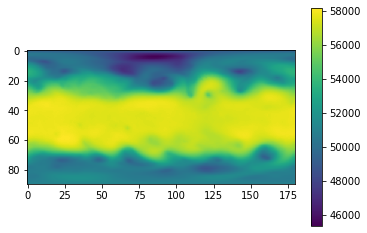

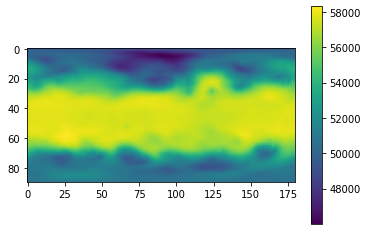

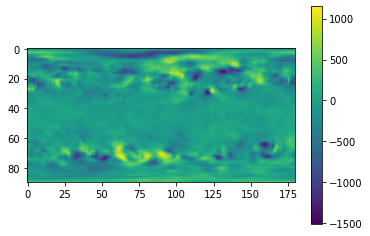

In [61]:
output_data_true = my_model.output_data_valid[:100]
plot_model(output_data_true[50][:,:,-1],output_data_pred[50][:,:,-1].numpy())

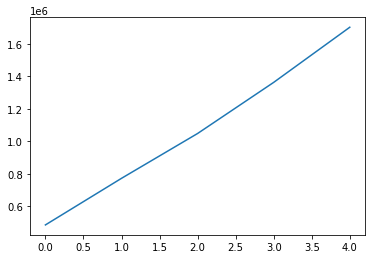

In [62]:
plot_model_error(output_data_true,output_data_pred.numpy())

### Reduce dimensionality of inputs

In [63]:
def generate_pod_bases(Y,K):
    '''
    Y - Snapshot matrix - shape: NxS
    returns V - truncated POD basis matrix - shape: NxK
    '''
    new_mat = np.matmul(np.transpose(Y),Y)
    w,v = np.linalg.eig(new_mat)

    # plt.figure()
    # plt.semilogy(w[:]/np.sum(w)*100)
    # plt.show()

    # Bases
    V = np.real(np.matmul(Y,v)) 
    trange = np.arange(np.shape(V)[1])
    V[:,trange] = V[:,trange]/np.sqrt(np.abs(w[:]))

    # Truncate phis
    V = V[:,0:K] # Columns are modes

    return V

In [ ]:
data_shape = z500_train.shape
z500_train = scaler.inverse_transform(z500_train.reshape(data_shape[0],-1))

num_modes = 40
z500_modes = generate_pod_bases(z500_train.T[:,:3650],num_modes)

z500_train = scaler.transform(z500_train).reshape(data_shape)

In [ ]:
# Output sensor locations
op_sensor_locations = np.zeros(shape=(1,z500_test.shape[1],z500_test.shape[2],my_model.output_horizon),dtype='int32')

op_sensor_locations = op_sensor_locations.reshape(1,-1)
op_rand_idx = np.arange(op_sensor_locations.shape[-1])
np.random.shuffle(op_rand_idx)
num_op_sensors = 10000

op_rand_idx = op_rand_idx[:num_op_sensors]
op_sensor_locations[0,op_rand_idx] = 1
op_sensor_locations = op_sensor_locations.reshape(1,z500_test.shape[1],z500_test.shape[2],my_model.output_horizon)

In [ ]:
my_model.make_data_test(z500_test)

### Check effect of modal representation of inputs

In [ ]:
test_input = my_model.input_data_test[0].reshape(-1,5).copy()
test_input = scaler.inverse_transform(test_input.T).T
coeff_input = np.matmul(z500_modes.T,test_input)

recon_input = np.matmul(coeff_input.T,z500_modes.T).T
recon_input = scaler.transform(recon_input.T).T
recon_input = recon_input.reshape(90,180,5)

test_input = scaler.transform(test_input.T).T
test_input = test_input.reshape(90,180,5)

plt.figure()
plt.imshow(test_input[:,:,0])
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(recon_input[:,:,0])
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(test_input[:,:,0]-recon_input[:,:,0])
plt.colorbar()
plt.show()

In [20]:
def residual(x,*args):
    '''
    x [num_modes*input_horizon],  - same locations as where output is observed are to be perturbed
    args: 
    (
    true_test_op [1,90,180,output_horizon], 
    z500_modes [90*180,num_modes] , op_rand_idx [num_op_sensors]
    model, scaler, input_horizon
    )
    '''   
    true_output = args[0]
    z500_modes = args[1]
    op_rand_idx = args[2]
    nn_model = args[3]
    scaler = args[4]
    input_horizon = args[5]
    op_data_shape = true_output.shape
    coeff_input = x.reshape(-1,input_horizon)
    
    # Reconstruct field with coefficient input and rescale
    recon_input = np.matmul(z500_modes,coeff_input) #[90*180,input_horizon]
    recon_input = scaler.transform(recon_input.T).T #[90*180,input_horizon]
    phys_input = recon_input.reshape(1,op_data_shape[1],op_data_shape[2],-1) #[1,90,180,input_horizon]
           
    # make prediction    
    prior = nn_model.call(phys_input).numpy()
    
    # Check background
    mse_prior = np.mean((prior-true_output)**2)
    
    # Check sensor error
    sparse_truth = true_output.reshape(1,-1)[0,op_rand_idx]
    sparse_pred = prior.reshape(1,-1)[0,op_rand_idx]
    
    mse_random_sparse = np.sum((sparse_pred-sparse_truth)**2)/(op_rand_idx.shape[0])

    return mse_prior + mse_random_sparse

### Testing the residual function

In [21]:
i = 10

input_horizon = my_model.input_data_test[i].shape[-1]
test_input = my_model.input_data_test[i].reshape(-1,5).copy()
test_input = scaler.inverse_transform(test_input.T).T
initial_guess = np.matmul(z500_modes.T,test_input)

true_output = my_model.output_data_test[i:i+1].copy()

residual(initial_guess,true_output,z500_modes,op_rand_idx,my_model,scaler,input_horizon) # Careful - arguments are changed in function

0.015677261158823966

In [68]:
def variational_da(model, op_rand_idx):
    # Assumption that data is already preprocessed
    num_inference = model.input_data_test.shape[0]
    
    for i in range(num_inference):
        input_horizon = my_model.input_data_test[i].shape[-1]
        
        test_input = my_model.input_data_test[i].reshape(-1,input_horizon).copy()
        test_input = scaler.inverse_transform(test_input.T).T
        initial_guess = np.matmul(z500_modes.T,test_input)
#         initial_guess = np.zeros_like(initial_guess)
        
        true_output = model.output_data_test[i:i+1].copy()        
        
        print('Initial residual:',residual(initial_guess,true_output,z500_modes,op_rand_idx,my_model,scaler,input_horizon))
        print('')
        
        solution = minimize(fun=residual,x0=initial_guess,args=(true_output,z500_modes,op_rand_idx,my_model,scaler,input_horizon)
                            ,method='SLSQP',
                            tol=1,
                            options={'disp': True, 'maxiter': 50})
        
        print('Final residual:',residual(solution.x,true_output,z500_modes,op_rand_idx,my_model,scaler,input_horizon))
        print('*******')
        print('')

In [69]:
variational_da(my_model,op_rand_idx)

Initial residual: 0.015882969820499422

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.015882977192103864
            Iterations: 1
            Function evaluations: 201
            Gradient evaluations: 1
Final residual: 0.015882977192103864
*******

Initial residual: 0.016350139497220514

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.016350148226320742
            Iterations: 1
            Function evaluations: 201
            Gradient evaluations: 1
Final residual: 0.016350148226320742
*******

Initial residual: 0.01635445715636015



KeyboardInterrupt: 